### Importing and critical values

In [ ]:
!pip install arch
import matplotlib.pyplot as plt
from arch.univariate import ARCH, ARX, LS
import numpy as np
import math
import random
from scipy import stats
from tqdm import tqdm
from arch import arch_model
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm



p_critical_values = {0.1: [(10, 1.8535), (5, 2.122), (1, 2.6515)],
                     0.3: [(10, 1.6491), (5, 1.8827), (1, 2.3526)],
                     0.5: [(10, 1.4601), (5, 1.6502), (1, 2.0346)],
                     0.7: [(10, 1.3075), (5, 1.4593), (1, 1.7685)],
                     0.9: [(10, 1.2186), (5, 1.349), (1, 1.6307)]}


updated_p_crit_values = {
    500: {0.9: [(1, 1.625109815486939), (5, 1.3401116521489924), (10, 1.1945078188700238)],
          0.7: [(1, 1.4922734138267977), (5, 1.215407324159195), (10, 1.0937257518196801)],
          0.5: [(1, 1.3426923442033325), (5, 1.1202655062608775), (10, 1.0225876541091923)],
          0.3: [(1, 1.4253017532539052), (5, 1.2006542947603238), (10, 1.0792737980471916)],
          0.1: [(1, 1.5995925087784877), (5, 1.3308875724148999), (10, 1.1941473886603153)]},
    1000: {0.9: [(1, 1.5883189297803526), (5, 1.3330970842801169), (10, 1.1940806892683957)],
           0.7: [(1, 1.4774201528681428), (5, 1.21603336820033), (10, 1.0994101490390502)],
           0.5: [(1, 1.354789075853397), (5, 1.1401604581793128), (10, 1.032353064740397)],
           0.3: [(1, 1.423167720401685), (5, 1.204593019822328), (10, 1.0859884573589795)],
           0.1: [(1, 1.6157943523133418), (5, 1.3377668365663855), (10, 1.2055743974590507)]},
    1500: {0.9: [(1, 1.5973479410813223), (5, 1.3397837532485901), (10, 1.2054661174812038)],
           0.7: [(1, 1.4467163283689346), (5, 1.2128300202796474), (10, 1.0957658171196099)],
           0.5: [(1, 1.3306530028161798), (5, 1.1415245488662251), (10, 1.0363349253079779)],
           0.3: [(1, 1.4233977802442384), (5, 1.2037246364545509), (10, 1.0899667510296)],
           0.1: [(1, 1.6148843276076996), (5, 1.3600057229119604), (10, 1.2206013945996625)]}}


# Simulation

###Base library for CUSUM statistics

#### Mean break

In [ ]:
def add_constant(ser, constant, fraction=0.5):
    """
    Add constant to a portion of the time-series.

    Parameters:
    - ser (dict): The time-series data, where ser['data'] is a list of values.
    - constant (float): The value to be added to the time-series.
    - start_fraction (float): Fraction indicating where to start adding the constant.
                              Value between 0 and 1. Default is 0.5.

    Returns:
    - new_ser (list): Time-series after adding the constant.
    """

    if not 0 <= fraction <= 1:
        raise ValueError("start_fraction should be between 0 and 1.")

    n = len(ser['data'])
    start_idx = math.ceil(n * fraction)

    arr = np.concatenate([np.full(start_idx, constant), np.zeros(n-start_idx)])
    new_ser = [i+j for i, j in zip(ser['data'], arr)]

    return new_ser

def add_structural_break(ser, params, fraction=0.5):
    """
    Simulate a time series with a structural break at a specified fraction.

    Parameters:
    - ser (pd.DataFrame): The original time series with columns 'data' and 'errors'.
    - params (list): Parameters for the new data generation process.
                     params[0] is the mean, params[1] is the constant variance component,
                     and params[2] is the lagged variance component.
    - fraction (float): The fraction of the series length where the structural break occurs.
                        Default is 0.5, i.e., at the halfway point.

    Returns:
    - pd.Series: The time series with the structural break.
    """

    # Calculate the point of structural break
    break_point = math.ceil(len(ser.index) * fraction)

    # Iterate from the break point till the end of the series
    for t in range(break_point, len(ser)):
        sigma2 = params[1] + params[2] * ser['errors'][t-1] ** 2
        ser['data'][t] = params[0] + np.random.normal(0,1) * np.sqrt(sigma2)

    return ser['data']




#### Vanilla ARCH CUSUM

In [ ]:
def compute_cusum_statistic_average_corrected(params, params_x,T=3000,fraction=0.5):
    sim_mod = arch_model(None, p=1, o=0, q=0, dist="normal")
    sim_data = sim_mod.simulate(params, nobs=T)
    if params[0]!= params_x[0] and (params[1:]==params_x[1:]).all():
        sim_data['data'] = add_constant(sim_data, params_x[0]-params[0],fraction)
    elif (params!=params_x).any():
        sim_data['data'] = add_structural_break(sim_data, params_x, fraction)
    res = arch_model(sim_data['data'], p=1, o=0, q=0, dist="normal").fit(disp="off")
    residuals = np.array(res.resid)
    mean_residual = np.mean(residuals)

#calculate the average-crrected residuals
    average_corrected_residuals = residuals - mean_residual
    process = average_corrected_residuals.cumsum() / np.std(residuals) / math.sqrt(T)
    sup_b = np.abs(process).max()
    return sup_b


def compute_cusum_statistic_squared(params, params_x,T=3000,fraction=0.5):
    sim_mod = arch_model(None, p=1, o=0, q=0, dist="normal")
    sim_data = sim_mod.simulate(params, nobs=T)

    res = arch_model(sim_data['data'], p=1, o=0, q=0, dist="normal").fit(disp="off")
    residuals = np.array(res.resid)
    residuals_squared = residuals**2 / np.array(res.conditional_volatility)**2
    mean_residuals_squared = np.mean(residuals_squared)

    average_corrected_residuals_squared = residuals_squared - mean_residuals_squared
    process = average_corrected_residuals_squared.cumsum() / np.std(residuals_squared) / math.sqrt(T)
    sup_b = np.abs(process).max()
    return sup_b

def monte_carlo_simulation(params, params_x, method = compute_cusum_statistic_average_corrected, n_simulations=1000, T=1500, fraction = 0.5):
    crit =[(1, 1.63), (5, 1.36), (10, 1.22)]
    exceed_counts = {level: 0 for  level,_ in crit}

    for _ in tqdm(range(n_simulations)):
        cusum_stat = method(params, params_x,  T, fraction)
        for level, value in crit:
            if cusum_stat > value:
                exceed_counts[level] += 1
    results = []
    for level, count in exceed_counts.items():
        results.append(count / n_simulations)
        print(f"Fraction of times CUSUM statistic for {params} before T/2 and {params_x} after T/2 exceeds {level}% critical value: {count / n_simulations:.4f}")
    return results


#monte_carlo_simulation( np.array([1, 0.1, 0.1]),  np.array([2, 0.1, 0.1]), method = compute_cusum_statistic_squared)
#monte_carlo_simulation( np.array([1, 0.1, 0.1]),  np.array([1.1, 0.1, 0.1]), method = compute_cusum_statistic_squared)
#monte_carlo_simulation( np.array([1, 0.1, 0.1]),  np.array([0.95, 0.1, 0.1]), method = compute_cusum_statistic_squared)
#monte_carlo_simulation( np.array([0, 0.2, 0.2]),  np.array([0, 0.2, 0.5]), method = compute_cusum_statistic_squared)

#monte_carlo_simulation( np.array([1, 0.1, 0.5]),  np.array([1.1,  0.1, 0.5]), method = compute_cusum_statistic_average_corrected)
#monte_carlo_simulation( np.array([1, 0.1, 0.5]),  np.array([0.95, 0.1, 0.5]), method = compute_cusum_statistic_average_corrected)
#monte_carlo_simulation( np.array([1, 0.1, 0.5]),  np.array([2,    0.1, 0.5]), method = compute_cusum_statistic_average_corrected)
#monte_carlo_simulation( np.array([0, 0.2, 0.2]),  np.array([0, 0.2, 0.5]), method = compute_cusum_statistic_average_corrected)


#### P-regressor ARCH-CUSUM (mean)

In [ ]:
def compute_cusum_statistic_p_regressor1(p_coef,lmbd, params, params_x,T=1500,fraction=0.5):

    I = (np.arange(T) <= round(p_coef * T)).astype(int)
    exog = pd.DataFrame({"I": I})
    sim_mod = arch_model(None, p=1, o=0, q=0, dist="normal")
    sim_data = sim_mod.simulate(params, nobs=T)
    if params[0]!= params_x[0] and (params[1:]==params_x[1:]).all():
        #sim_data['data'] = add_constant(sim_data, params_x[0]-params[0],fraction)
        mean_change = np.array([0 if t <= T//2 else params_x[0]-params[0] for t in range(T)])
        sim_data['data'] = sim_data['data']+mean_change
    elif (params!=params_x).any():
        sim_data['data'] = add_structural_break(sim_data, params_x, fraction)
    sim_data['data'] = exog['I'] * lmbd + sim_data['data']

    # Model using arch
    model = arch_model(sim_data['data'], x=exog, mean='ARX', lags=0, vol='ARCH', p=1)
    res = model.fit(disp="off")
    # print(res.params)
    s = np.arange(1/T, 1 + 1/T, 1/T)
    residuals = np.array(res.resid) - res.params[0]
    residuals_cusum = residuals.cumsum()
    process = (residuals_cusum - (np.minimum(s, p_coef)/ p_coef) * residuals_cusum[-1] ) / np.std(residuals) / math.sqrt(T)
    sup_b = np.abs(process).max()
    return sup_b



def monte_carlo_simulation_p_regressor1(p_coef,lmbd, params, params_x, n_simulations=1000, T=1500, fraction = 0.5):
    p_crit = p_critical_values[p_coef]
    exceed_counts = {level: 0 for  level,_ in p_crit}


    for _ in tqdm(range(n_simulations)):
        cusum_stat = compute_cusum_statistic_p_regressor1(p_coef,lmbd, params, params_x,  T, fraction)
        for level, value in p_crit:
            if cusum_stat > value:
                exceed_counts[level] += 1
    results = []

    for level, count in exceed_counts.items():
        results.append(count / n_simulations)
        print(f"Fraction of times CUSUM statistic with p = {p_coef} for {params} before T/2 and {params_x} after T/2 exceeds {level}% critical value: {count / n_simulations:.4f}")
    return results


monte_carlo_simulation_p_regressor1(0.5, 5, np.array([0, 0.2, 0.2]),  np.array([0, 0.2, 0.2]))
monte_carlo_simulation_p_regressor1(0.5, 5, np.array([0, 0.2, 0.2]),  np.array([0, 0.2, 0.2]))
# monte_carlo_simulation_p_regressor(0.7, 5, np.array([0, 0.2, 0.2]),  np.array([1, 0.2, 0.2]))
# monte_carlo_simulation_p_regressor(0.5, 5, np.array([0, 0.2, 0.2]),  np.array([1, 0.2, 0.2]))
# monte_carlo_simulation_p_regressor(0.3, 5, np.array([0, 0.2, 0.2]),  np.array([1, 0.2, 0.2]))
# monte_carlo_simulation_p_regressor(0.1, 5, np.array([0, 0.2, 0.2]),  np.array([1, 0.2, 0.2]))


# monte_carlo_simulation_p_regressor(0.9, 5, np.array([0, 0.2, 0.2]),  np.array([10, 0.2, 0.2]))
# monte_carlo_simulation_p_regressor(0.7, 5, np.array([0, 0.2, 0.2]),  np.array([10, 0.2, 0.2]))
# monte_carlo_simulation_p_regressor(0.5, 5, np.array([0, 0.2, 0.2]),  np.array([10, 0.2, 0.2]))
# monte_carlo_simulation_p_regressor(0.3, 5, np.array([0, 0.2, 0.2]),  np.array([10, 0.2, 0.2]))
# monte_carlo_simulation_p_regressor(0.1, 5, np.array([0, 0.2, 0.2]),  np.array([10, 0.2, 0.2]))


100%|██████████| 1/1 [00:00<00:00, 26.03it/s]


Const       0.011746
I           4.999416
omega       0.220554
alpha[1]    0.246101
Name: params, dtype: float64
Fraction of times CUSUM statistic with p = 0.5 for [0.  0.2 0.2] before T/2 and [0.  0.2 0.2] after T/2 exceeds 10% critical value: 0.0000
Fraction of times CUSUM statistic with p = 0.5 for [0.  0.2 0.2] before T/2 and [0.  0.2 0.2] after T/2 exceeds 5% critical value: 0.0000
Fraction of times CUSUM statistic with p = 0.5 for [0.  0.2 0.2] before T/2 and [0.  0.2 0.2] after T/2 exceeds 1% critical value: 0.0000


100%|██████████| 1/1 [00:00<00:00, 24.10it/s]

Const      -0.000439
I           4.999192
omega       0.192865
alpha[1]    0.201467
Name: params, dtype: float64
Fraction of times CUSUM statistic with p = 0.5 for [0.  0.2 0.2] before T/2 and [0.  0.2 0.2] after T/2 exceeds 10% critical value: 0.0000
Fraction of times CUSUM statistic with p = 0.5 for [0.  0.2 0.2] before T/2 and [0.  0.2 0.2] after T/2 exceeds 5% critical value: 0.0000
Fraction of times CUSUM statistic with p = 0.5 for [0.  0.2 0.2] before T/2 and [0.  0.2 0.2] after T/2 exceeds 1% critical value: 0.0000


[0.0, 0.0, 0.0]

#### P-regressor ARCH-CUSUM (lambda)

#### P-regressor iid

In [ ]:

# Simulating the time series based on the type of change
def simulate_time_series(mean, p_coef, lmbd, change_type, change_power, T):
    u = np.random.randn(T)
    #print(round(T/2-5),round(T/2+5))
    #print("error", u[round(T/2-5):round(T/2+5)])
    if change_power != 0:
        if change_type == "mean":
            mean_change = np.array([0 if t <= T//2 else change_power for t in range(T)])
            y = mean + lmbd * (np.array([1 if t <= round(p_coef*T) else 0 for t in range(T)])) + u + mean_change
        elif change_type == "lambda":
            lmbd_change = np.array([change_power if t <= p_coef/2*T else lmbd + change_power for t in range(T)])
            y = mean + lmbd * (np.array([1 if t <= round(p_coef*T) else 0 for t in range(T)])) + u + lmbd_change
    else:
        # print(np.array([1 if t <= p_coef*T else 0 for t in range(T)]))
        y = mean + lmbd * np.array([1 if t <= round(p_coef*T) else 0 for t in range(T)]) + u
    # print(y)
    return y

# Computing the CUSUM statistic
def compute_cusum_statistic_iid(y, p_coef, T):
    I = np.array([1 if t <= round(p_coef*T) else 0 for t in range(T)])

    X = sm.add_constant(I)  # Adding a constant for intercept

    # Using GLM with a Gaussian family (equivalent to OLS)
    # model = sm.GLM(y, X, family=sm.families.Gaussian())
    # result = model.fit()
    # #print(result.summary())
    # residuals = result.resid_response - result.params[0]
    #print(residuals[round(T/2-5):round(T/2+5)])

    model = LinearRegression(fit_intercept=True)
    # #model = LS(y, x=I, distribution = "Normal")
    res = model.fit(I.reshape(-1, 1), y)
    prediction = res.predict(I.reshape(-1, 1))
    # print(prediction)
    residuals = (y - prediction)- res.intercept_
    s = np.arange(0, 1 , 1/T)
    residuals_cusum = residuals.cumsum()
    stat = np.abs((residuals_cusum - (np.minimum(s, p_coef) / p_coef) * residuals_cusum[-1] )).max() / np.std(residuals) / math.sqrt(T)

    return stat

# Monte Carlo simulation
def iid_monte_carlo_simulation(mean, p_coef, lmbd, change_type, change_power, T, n_simulations=1000):
    exceed_counts = {level: 0 for level, _ in p_critical_values[p_coef]}
    #cusum_stats = []
    for _ in tqdm(range(n_simulations)):
        y = simulate_time_series(mean, p_coef, lmbd, change_type, change_power, T)
        cusum_stat = compute_cusum_statistic_iid(y, p_coef, T)
        #cusum_stats.append(cusum_stat)
        for level, value in p_critical_values[p_coef]:
            if cusum_stat > value:
                exceed_counts[level] += 1

    results = []

    for level, count in exceed_counts.items():
        results.append(count / n_simulations)
        print(f"Fraction of times CUSUM statistic with p = {p_coef} for {change_type} change exceeds {level}% critical value: {count / n_simulations:.4f}")

    return results

# Running the simulation for mean change
iid_monte_carlo_simulation(0, 0.1, 5, "mean", 0.1, n_simulations=1000, T=1000)





100%|██████████| 1000/1000 [00:04<00:00, 242.75it/s]

Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 10% critical value: 0.4170
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 5% critical value: 0.3110
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 1% critical value: 0.1640


[0.417, 0.311, 0.164]

#### Seasonal dummies

In [ ]:
def compute_cusum_statistic_seasonal(params, params_x,T=3000,fraction=0.5):
    sim_mod = arch_model(None, p=1, o=0, q=0, dist="normal")
    x1 = (np.arange(T)%4==0).astype(int)
    x2 = (np.arange(T)%4==1).astype(int)
    x3 = (np.arange(T)%4==2).astype(int)
    #x4 = (np.arange(T)%4==3).astype(int)
    lambda_1, lambda_2,lambda_3 =  params[1:]
    exog = pd.DataFrame({"x1": x1,"x2": x2,"x3": x3})
    sim_data = sim_mod.simulate(np.array([0, 0.2, 0.2]), nobs=T)
    sim_data['data'] = sim_data['data']  + exog['x1']*lambda_1 +exog['x2']*lambda_2+ exog['x3']*lambda_3

    if params[0]!= params_x[0] and (params[1:]==params_x[1:]).all():
        sim_data['data'] = add_constant(sim_data, params_x[0]-params[0],fraction)
    elif (params!=params_x).any():
        lambda_part = exog['x1']*(params_x[1]-params[1]) +exog['x2']*(params_x[2]-params[2]) + exog['x3']*(params_x[3]-params[3])
        shift = np.concatenate([np.zeros(round(T*fraction)), lambda_part[round(T*fraction):]])
        sim_data['data'] = sim_data['data'] + shift
    res = arch_model(y = sim_data['data'], x = exog, mean='ARX', lags=0, vol='ARCH', p=1).fit(disp="off")
    residuals = np.array(res.resid)
    mean_residual = np.mean(residuals)

#calculate the average-crrected residuals
    average_corrected_residuals = residuals - mean_residual
    process = average_corrected_residuals.cumsum() / np.std(residuals) / math.sqrt(T)
    sup_b = np.abs(process).max()
    return sup_b



def monte_carlo_simulation_seasonal(params, params_x, n_simulations=1000, T=1500, fraction = 0.5):
    crit =[(1, 1.63), (5, 1.36), (10, 1.22)]
    exceed_counts = {level: 0 for  level,_ in crit}

    for _ in tqdm(range(n_simulations)):
        cusum_stat = compute_cusum_statistic_seasonal(params, params_x,  T, fraction)
        for level, value in crit:
            if cusum_stat > value:
                exceed_counts[level] += 1
    results = []
    print("Old params mean and lambdas:", ["{0:0.2f}".format(i) for i in params], "New:", ["{0:0.2f}".format(i) for i in params_x])
    for level, count in exceed_counts.items():
        results.append(count / n_simulations)
        #print("Old params mean and lambdas:", ["{0:0.2f}".format(i) for i in params], "New:", ["{0:0.2f}".format(i) for i in params_x])
        print(f"Fraction of times CUSUM statistic for break before {fraction} and with T={T} exceeds {level}% critical value: {count / n_simulations:.4f}")
    return results


#monte_carlo_simulation_seasonal( np.array([0, 2, 3, 4]),  np.array([0.1, 2, 3, 4]), fraction = 0.5)
#monte_carlo_simulation( np.array([1, 0.1, 0.1]),  np.array([1.1, 0.1, 0.1]), method = compute_cusum_statistic_squared)
#monte_carlo_simulation( np.array([1, 0.1, 0.1]),  np.array([0.95, 0.1, 0.1]), method = compute_cusum_statistic_squared)
#monte_carlo_simulation( np.array([0, 0.2, 0.2]),  np.array([0, 0.2, 0.5]), method = compute_cusum_statistic_squared)

#monte_carlo_simulation( np.array([1, 0.1, 0.5]),  np.array([1.1,  0.1, 0.5]), method = compute_cusum_statistic_average_corrected)
#monte_carlo_simulation( np.array([1, 0.1, 0.5]),  np.array([0.95, 0.1, 0.5]), method = compute_cusum_statistic_average_corrected)
#monte_carlo_simulation( np.array([1, 0.1, 0.5]),  np.array([2,    0.1, 0.5]), method = compute_cusum_statistic_average_corrected)
#monte_carlo_simulation( np.array([0, 0.2, 0.2]),  np.array([0, 0.2, 0.5]), method = compute_cusum_statistic_average_corrected)


### Running simulations for base ARCH

In [ ]:
import os
import pandas as pd

def run_simulations():
    # Define the parameters
    fractions = [0.1, 0.3, 0.5, 0.7, 0.9]
    T_values = [500, 1000, 1500]
    means = [0.1, 0.05, 0.5, 1, 0]
    base_params = [np.array([0, 0.2, 0.2]), np.array([0, 0.4, 0.4]), np.array([0, 0.2, 0.4]), np.array([0, 0.4, 0.2])]

    # Filename for saving and loading results
    filename = "simulation_results_1000_900param.csv"

    # Load existing results if the CSV file exists
    if os.path.exists(filename):
        df_existing = pd.read_csv(filename)
        last_row = df_existing.iloc[-1]

        start_fraction_index = fractions.index(last_row['fraction'])
        start_T_index = T_values.index(last_row['T'])
        start_mean_index = means.index(last_row['mean_change'])
        #start_base_params_index = base_params.index(np.array(eval(last_row['base_parameters'])))
    else:
        df_existing = pd.DataFrame()
        start_fraction_index, start_T_index, start_mean_index = 0, 0, 0

    # Iterate through parameters, starting from the saved positions
    for fraction_index in range(start_fraction_index, len(fractions)):
        fraction = fractions[fraction_index]

        for T_index in range(start_T_index, len(T_values)):
            T = T_values[T_index]

            for mean_index in range(start_mean_index, len(means)):
                mean = means[mean_index]

                for base_param_index in range(len(base_params)):
                    base_param = base_params[base_param_index]

                    params_x = base_param.copy()
                    params_x[0] = mean

                    sim_result = monte_carlo_simulation(base_param, params_x, method=compute_cusum_statistic_average_corrected, n_simulations=1000, T=T, fraction=fraction)

                    row = {'fraction': fraction, 'T': T, 'mean_change': mean, 'base_parameters': str(base_param), 'result': sim_result}

                    # Save the result of this iteration to the CSV file
                    df = pd.DataFrame([row])
                    df.to_csv(filename, mode='a', header=not os.path.exists(filename), index=False)

                    # Reset indices for inner loops
                    if base_param_index == len(base_params) - 1:
                        start_base_params_index = 0
                    if mean_index == len(means) - 1:
                        start_mean_index = 0
                    if T_index == len(T_values) - 1:
                        start_T_index = 0

run_simulations()

import pandas as pd

# Load the data
data = pd.read_csv('simulation_results_1000_900params.csv')

data['result'] = data['result'].str.strip('[]').str.split(',').apply(lambda x: [float(item.strip()) for item in x])

# Create new columns based on the significance levels
data['1%_significance'] = data['result'].apply(lambda x: x[0])
data['5%_significance'] = data['result'].apply(lambda x: x[1])
data['10%_significance'] = data['result'].apply(lambda x: x[2])

# Drop the original 'result' column
data = data.drop(columns='result')

# Save the updated dataset to a new CSV file
file_path = "updated_simulation_results_1000_900params.csv"
data.to_csv(file_path, index=False)



### Running simulations for P-regressor ARCH (mean)

In [ ]:
import os
import pandas as pd

def mean_change_p_run_simulations():
    # Define the parameters
    p_fractions = [0.1, 0.3, 0.5, 0.7, 0.9]
    T_values = [500, 1000, 1500]
    means = [0.1, 0.05, 0.5, 1, 0]
    base_params = [np.array([0, 0.2, 0.2])]
    lmbd = 2

    # Filename for saving and loading results
    filename = "mean_change_simulation_results_p_1000.csv"

    # Load existing results if the CSV file exists
    if os.path.exists(filename):
        df_existing = pd.read_csv(filename)
        last_row = df_existing.iloc[-1]

        start_fraction_index = p_fractions.index(last_row['fraction'])
        start_T_index = T_values.index(last_row['T'])
        start_mean_index = means.index(last_row['mean_change'])
        #start_base_params_index = base_params.index(np.array(eval(last_row['base_parameters'])))
    else:
        df_existing = pd.DataFrame()
        start_fraction_index, start_T_index, start_mean_index = 0, 0, 0

    # Iterate through parameters, starting from the saved positions
    for p_fraction_index in range(start_fraction_index, len(p_fractions)):
        p_fraction = p_fractions[p_fraction_index]

        for T_index in range(start_T_index, len(T_values)):
            T = T_values[T_index]

            for mean_index in range(start_mean_index, len(means)):
                mean = means[mean_index]

                for base_param_index in range(len(base_params)):
                    base_param = base_params[base_param_index]

                    params_x = base_param.copy()
                    params_x[0] = mean

                    sim_result = monte_carlo_simulation_p_regressor1(p_fraction, lmbd, base_param,params_x, n_simulations=1000, T=T)

                    row = {'p_fraction': p_fraction, 'T': T, 'mean_change': mean, 'base_parameters': str(base_param), 'result': sim_result}

                    # Save the result of this iteration to the CSV file
                    df = pd.DataFrame([row])
                    df.to_csv(filename, mode='a', header=not os.path.exists(filename), index=False)

                    # Reset indices for inner loops
                    if base_param_index == len(base_params) - 1:
                        start_base_params_index = 0
                    if mean_index == len(means) - 1:
                        start_mean_index = 0
                    if T_index == len(T_values) - 1:
                        start_T_index = 0

mean_change_p_run_simulations()

# Load the data
data = pd.read_csv('mean_change_simulation_results_p_1000.csv')

data['result'] = data['result'].str.strip('[]').str.split(',').apply(lambda x: [float(item.strip()) for item in x])

# Create new columns based on the significance levels
data['1%_significance'] = data['result'].apply(lambda x: x[0])
data['5%_significance'] = data['result'].apply(lambda x: x[1])
data['10%_significance'] = data['result'].apply(lambda x: x[2])

# Drop the original 'result' column
data = data.drop(columns='result')

# Save the updated dataset to a new CSV file
file_path = "mean_change_simulation_results_p_1000.csv"
data.to_csv(file_path, index=False)

NameError: ignored

### Running simulation for P-regressor ARCH (lambda)

In [ ]:
def compute_cusum_statistic_p_regressor_lambda(p_coef,lmbd, lambda_change,  params,T=3000):

    I = (np.arange(T) <= p_coef * T).astype(int)
    exog = pd.DataFrame({"I": I})
    sim_mod = arch_model(None, p=1, o=0, q=0, dist="normal")
    sim_data = sim_mod.simulate(params, nobs=T)
    sim_data['data'] = exog['I'] * lmbd + sim_data['data']
    sim_data['data'] = add_constant(sim_data, lambda_change,p_coef/2)


    # Model using arch
    model = arch_model(sim_data['data'], x=exog, mean='ARX', lags=0, vol='ARCH', p=1)
    res = model.fit(disp="off")
    s = np.arange(1/T, 1 + 1/T, 1/T)
    residuals = np.array(res.resid)-res.params[0]
    residuals_cusum = residuals.cumsum()
    process = (residuals_cusum - (np.minimum(s, p_coef)/ p_coef) * residuals_cusum[-1] ) / np.std(residuals) / math.sqrt(T)
    sup_b = np.abs(process).max()
    return sup_b



def monte_carlo_simulation_p_regressor_lambda(p_coef,lmbd, lambda_change, params, n_simulations=1000, T=1500, fraction = 0.5):
    p_crit = p_critical_values[p_coef]
    exceed_counts = {level: 0 for  level,_ in p_crit}


    for _ in tqdm(range(n_simulations)):
        cusum_stat = compute_cusum_statistic_p_regressor_lambda(p_coef,lmbd, lambda_change, params,  T)
        for level, value in p_crit:
            if cusum_stat > value:
                exceed_counts[level] += 1
    results = []

    for level, count in exceed_counts.items():
        results.append(count / n_simulations)
        print(f"Fraction of times CUSUM statistic with lambda_change = {lambda_change} and p = {p_coef}  exceeds {level}% critical value: {count / n_simulations:.4f}")
    return results



import os
import pandas as pd

def mean_change_p_run_simulations():
    # Define the parameters
    p_fractions = [0.1, 0.3, 0.5, 0.7, 0.9]
    T_values = [500, 1000, 1500]
    lambda_change = [0.1, 0.05, 0.5, 1, 0]
    base_params = [np.array([0, 0.2, 0.2])]
    lmbd = 1

    # Filename for saving and loading results
    filename = "lambda_change_simulation_results_p_1000.csv"

    # Load existing results if the CSV file exists
    if os.path.exists(filename):
        df_existing = pd.read_csv(filename)
        last_row = df_existing.iloc[-1]

        start_fraction_index = p_fractions.index(last_row['p_fraction'])
        start_T_index = T_values.index(last_row['T'])
        start_lambda_change_index = lambda_change.index(last_row['lambda_change'])
        #start_base_params_index = base_params.index(np.array(eval(last_row['base_parameters'])))
    else:
        df_existing = pd.DataFrame()
        start_fraction_index, start_T_index, start_lambda_change_index = 0, 0, 0

    # Iterate through parameters, starting from the saved positions
    for p_fraction_index in range(start_fraction_index, len(p_fractions)):
        p_fraction = p_fractions[p_fraction_index]

        for T_index in range(start_T_index, len(T_values)):
            T = T_values[T_index]

            for lambda_change_index in range(start_lambda_change_index, len(lambda_change)):
                new_lambda_change = lambda_change[lambda_change_index]

                for base_param_index in range(len(base_params)):
                    base_param = base_params[base_param_index]

                    sim_result = monte_carlo_simulation_p_regressor_lambda(p_fraction, lmbd, new_lambda_change, base_param, n_simulations=1000, T=T)

                    row = {'p_fraction': p_fraction, 'T': T, 'lambda_change': new_lambda_change, 'base_parameters': str(base_param), 'result': sim_result}

                    # Save the result of this iteration to the CSV file
                    df = pd.DataFrame([row])
                    df.to_csv(filename, mode='a', header=not os.path.exists(filename), index=False)

                    # Reset indices for inner loops
                    if base_param_index == len(base_params) - 1:
                        start_base_params_index = 0
                    if lambda_change_index == len(lambda_change) - 1:
                        start_lambda_change_index = 0
                    if T_index == len(T_values) - 1:
                        start_T_index = 0

mean_change_p_run_simulations()

# Load the data
data = pd.read_csv('lambda_change_simulation_results_p_1000.csv')

data['result'] = data['result'].str.strip('[]').str.split(',').apply(lambda x: [float(item.strip()) for item in x])

# Create new columns based on the significance levels
data['1%_significance'] = data['result'].apply(lambda x: x[0])
data['5%_significance'] = data['result'].apply(lambda x: x[1])
data['10%_significance'] = data['result'].apply(lambda x: x[2])

# Drop the original 'result' column
data = data.drop(columns='result')

# Save the updated dataset to a new CSV file
file_path = "lambda_change_simulation_results_p_1000.csv"
data.to_csv(file_path, index=False)


100%|██████████| 1000/1000 [00:26<00:00, 37.43it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.1  exceeds 10% critical value: 0.0970
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.1  exceeds 5% critical value: 0.0460
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.1  exceeds 1% critical value: 0.0050


100%|██████████| 1000/1000 [00:26<00:00, 37.71it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.1  exceeds 10% critical value: 0.0920
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.1  exceeds 5% critical value: 0.0440
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.1  exceeds 1% critical value: 0.0150


100%|██████████| 1000/1000 [00:27<00:00, 36.10it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.1  exceeds 10% critical value: 0.0890
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.1  exceeds 5% critical value: 0.0460
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.1  exceeds 1% critical value: 0.0140


100%|██████████| 1000/1000 [00:25<00:00, 38.91it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.1  exceeds 10% critical value: 0.0900
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.1  exceeds 5% critical value: 0.0440
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.1  exceeds 1% critical value: 0.0080


100%|██████████| 1000/1000 [00:25<00:00, 39.83it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.1  exceeds 10% critical value: 0.0910
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.1  exceeds 5% critical value: 0.0440
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.1  exceeds 1% critical value: 0.0120


100%|██████████| 1000/1000 [00:29<00:00, 34.05it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.1  exceeds 10% critical value: 0.0900
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.1  exceeds 5% critical value: 0.0460
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.1  exceeds 1% critical value: 0.0100


100%|██████████| 1000/1000 [00:28<00:00, 35.32it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.1  exceeds 10% critical value: 0.1090
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.1  exceeds 5% critical value: 0.0500
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.1  exceeds 1% critical value: 0.0070


100%|██████████| 1000/1000 [00:28<00:00, 34.98it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.1  exceeds 10% critical value: 0.0910
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.1  exceeds 5% critical value: 0.0430
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.1  exceeds 1% critical value: 0.0040


100%|██████████| 1000/1000 [00:30<00:00, 33.10it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.1  exceeds 10% critical value: 0.2890
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.1  exceeds 5% critical value: 0.1340
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.1  exceeds 1% critical value: 0.0170


100%|██████████| 1000/1000 [00:29<00:00, 34.11it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.1  exceeds 10% critical value: 0.0930
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.1  exceeds 5% critical value: 0.0450
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.1  exceeds 1% critical value: 0.0110


100%|██████████| 1000/1000 [00:31<00:00, 31.54it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.1  exceeds 10% critical value: 0.1050
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.1  exceeds 5% critical value: 0.0510
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.1  exceeds 1% critical value: 0.0100


100%|██████████| 1000/1000 [00:32<00:00, 30.82it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.1  exceeds 10% critical value: 0.1050
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.1  exceeds 5% critical value: 0.0610
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.1  exceeds 1% critical value: 0.0170


100%|██████████| 1000/1000 [00:32<00:00, 30.83it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.1  exceeds 10% critical value: 0.1080
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.1  exceeds 5% critical value: 0.0500
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.1  exceeds 1% critical value: 0.0110


100%|██████████| 1000/1000 [00:33<00:00, 29.92it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.1  exceeds 10% critical value: 0.5090
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.1  exceeds 5% critical value: 0.2890
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.1  exceeds 1% critical value: 0.0550


100%|██████████| 1000/1000 [00:33<00:00, 29.89it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.1  exceeds 10% critical value: 0.0960
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.1  exceeds 5% critical value: 0.0550
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.1  exceeds 1% critical value: 0.0100


100%|██████████| 1000/1000 [00:25<00:00, 39.44it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.3  exceeds 10% critical value: 0.1180
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.3  exceeds 5% critical value: 0.0580
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.3  exceeds 1% critical value: 0.0060


100%|██████████| 1000/1000 [00:25<00:00, 39.63it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.3  exceeds 10% critical value: 0.0940
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.3  exceeds 5% critical value: 0.0490
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.3  exceeds 1% critical value: 0.0080


100%|██████████| 1000/1000 [00:25<00:00, 39.48it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.3  exceeds 10% critical value: 0.5580
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.3  exceeds 5% critical value: 0.3400
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.3  exceeds 1% critical value: 0.0760


100%|██████████| 1000/1000 [00:25<00:00, 38.94it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.3  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.3  exceeds 5% critical value: 0.9950
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.3  exceeds 1% critical value: 0.9410


100%|██████████| 1000/1000 [00:25<00:00, 39.63it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.3  exceeds 10% critical value: 0.1220
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.3  exceeds 5% critical value: 0.0600
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.3  exceeds 1% critical value: 0.0140


100%|██████████| 1000/1000 [00:28<00:00, 34.98it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.3  exceeds 10% critical value: 0.0990
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.3  exceeds 5% critical value: 0.0490
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.3  exceeds 1% critical value: 0.0140


100%|██████████| 1000/1000 [00:28<00:00, 34.57it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.3  exceeds 10% critical value: 0.1110
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.3  exceeds 5% critical value: 0.0570
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.3  exceeds 1% critical value: 0.0130


100%|██████████| 1000/1000 [00:29<00:00, 33.56it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.3  exceeds 10% critical value: 0.9580
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.3  exceeds 5% critical value: 0.8420
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.3  exceeds 1% critical value: 0.4900


100%|██████████| 1000/1000 [00:30<00:00, 33.10it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.3  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.3  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.3  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:28<00:00, 34.78it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.3  exceeds 10% critical value: 0.0940
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.3  exceeds 5% critical value: 0.0550
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.3  exceeds 1% critical value: 0.0130


100%|██████████| 1000/1000 [00:33<00:00, 29.81it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.3  exceeds 10% critical value: 0.1130
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.3  exceeds 5% critical value: 0.0440
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.3  exceeds 1% critical value: 0.0100


100%|██████████| 1000/1000 [00:31<00:00, 31.53it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.3  exceeds 10% critical value: 0.1030
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.3  exceeds 5% critical value: 0.0490
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.3  exceeds 1% critical value: 0.0110


100%|██████████| 1000/1000 [00:33<00:00, 29.97it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.3  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.3  exceeds 5% critical value: 0.9840
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.3  exceeds 1% critical value: 0.8540


100%|██████████| 1000/1000 [00:31<00:00, 31.62it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.3  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.3  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.3  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:34<00:00, 29.05it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.3  exceeds 10% critical value: 0.1020
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.3  exceeds 5% critical value: 0.0440
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.3  exceeds 1% critical value: 0.0090


100%|██████████| 1000/1000 [00:24<00:00, 40.01it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.5  exceeds 10% critical value: 0.1330
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.5  exceeds 5% critical value: 0.0610
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.5  exceeds 1% critical value: 0.0110


100%|██████████| 1000/1000 [00:25<00:00, 39.75it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.5  exceeds 10% critical value: 0.1210
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.5  exceeds 5% critical value: 0.0580
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.5  exceeds 1% critical value: 0.0120


100%|██████████| 1000/1000 [00:24<00:00, 40.14it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.5  exceeds 10% critical value: 0.9980
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.5  exceeds 5% critical value: 0.9930
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.5  exceeds 1% critical value: 0.9300


100%|██████████| 1000/1000 [00:25<00:00, 39.66it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.5  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.5  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.5  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:24<00:00, 40.03it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.5  exceeds 10% critical value: 0.1050
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.5  exceeds 5% critical value: 0.0570
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.5  exceeds 1% critical value: 0.0160


100%|██████████| 1000/1000 [00:29<00:00, 33.72it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.5  exceeds 10% critical value: 0.2090
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.5  exceeds 5% critical value: 0.1090
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.5  exceeds 1% critical value: 0.0210


100%|██████████| 1000/1000 [00:28<00:00, 34.66it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.5  exceeds 10% critical value: 0.1210
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.5  exceeds 5% critical value: 0.0610
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.5  exceeds 1% critical value: 0.0130


100%|██████████| 1000/1000 [00:29<00:00, 33.44it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.5  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.5  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.5  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:29<00:00, 33.67it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.5  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.5  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.5  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:29<00:00, 34.11it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.5  exceeds 10% critical value: 0.0870
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.5  exceeds 5% critical value: 0.0370
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.5  exceeds 1% critical value: 0.0070


100%|██████████| 1000/1000 [00:32<00:00, 31.11it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.5  exceeds 10% critical value: 0.2870
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.5  exceeds 5% critical value: 0.1770
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.5  exceeds 1% critical value: 0.0360


100%|██████████| 1000/1000 [00:33<00:00, 29.91it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.5  exceeds 10% critical value: 0.1300
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.5  exceeds 5% critical value: 0.0650
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.5  exceeds 1% critical value: 0.0130


100%|██████████| 1000/1000 [00:31<00:00, 31.27it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.5  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.5  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.5  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:33<00:00, 30.20it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.5  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.5  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.5  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:33<00:00, 29.49it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.5  exceeds 10% critical value: 0.0890
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.5  exceeds 5% critical value: 0.0520
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.5  exceeds 1% critical value: 0.0060


100%|██████████| 1000/1000 [00:24<00:00, 40.18it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.7  exceeds 10% critical value: 0.2620
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.7  exceeds 5% critical value: 0.1660
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.7  exceeds 1% critical value: 0.0450


100%|██████████| 1000/1000 [00:25<00:00, 39.31it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.7  exceeds 10% critical value: 0.1500
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.7  exceeds 5% critical value: 0.0820
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.7  exceeds 1% critical value: 0.0200


100%|██████████| 1000/1000 [00:25<00:00, 38.92it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.7  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.7  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.7  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:26<00:00, 37.98it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.7  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.7  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.7  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:25<00:00, 39.20it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.7  exceeds 10% critical value: 0.0710
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.7  exceeds 5% critical value: 0.0360
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.7  exceeds 1% critical value: 0.0100


100%|██████████| 1000/1000 [00:30<00:00, 33.28it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.7  exceeds 10% critical value: 0.4860
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.7  exceeds 5% critical value: 0.3600
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.7  exceeds 1% critical value: 0.1560


100%|██████████| 1000/1000 [00:29<00:00, 34.42it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.7  exceeds 10% critical value: 0.2020
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.7  exceeds 5% critical value: 0.1180
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.7  exceeds 1% critical value: 0.0320


100%|██████████| 1000/1000 [00:30<00:00, 33.15it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.7  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.7  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.7  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:28<00:00, 34.56it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.7  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.7  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.7  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:29<00:00, 33.51it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.7  exceeds 10% critical value: 0.0870
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.7  exceeds 5% critical value: 0.0440
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.7  exceeds 1% critical value: 0.0110


100%|██████████| 1000/1000 [00:32<00:00, 30.79it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.7  exceeds 10% critical value: 0.6750
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.7  exceeds 5% critical value: 0.5580
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.7  exceeds 1% critical value: 0.2950


100%|██████████| 1000/1000 [00:33<00:00, 29.92it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.7  exceeds 10% critical value: 0.2540
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.7  exceeds 5% critical value: 0.1670
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.7  exceeds 1% critical value: 0.0440


100%|██████████| 1000/1000 [00:32<00:00, 30.88it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.7  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.7  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.7  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:33<00:00, 29.79it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.7  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.7  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.7  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:33<00:00, 29.93it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.7  exceeds 10% critical value: 0.0900
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.7  exceeds 5% critical value: 0.0430
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.7  exceeds 1% critical value: 0.0050


100%|██████████| 1000/1000 [00:25<00:00, 39.01it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.9  exceeds 10% critical value: 0.5560
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.9  exceeds 5% critical value: 0.4340
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.9  exceeds 1% critical value: 0.2090


100%|██████████| 1000/1000 [00:25<00:00, 38.93it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.9  exceeds 10% critical value: 0.2220
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.9  exceeds 5% critical value: 0.1330
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.9  exceeds 1% critical value: 0.0360


100%|██████████| 1000/1000 [00:25<00:00, 38.90it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.9  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.9  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.9  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:26<00:00, 37.50it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.9  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.9  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.9  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:25<00:00, 38.99it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.9  exceeds 10% critical value: 0.0860
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.9  exceeds 5% critical value: 0.0450
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.9  exceeds 1% critical value: 0.0070


100%|██████████| 1000/1000 [00:30<00:00, 32.49it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.9  exceeds 10% critical value: 0.7640
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.9  exceeds 5% critical value: 0.6710
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.9  exceeds 1% critical value: 0.4490


100%|██████████| 1000/1000 [00:28<00:00, 34.63it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.9  exceeds 10% critical value: 0.3350
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.9  exceeds 5% critical value: 0.2360
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.9  exceeds 1% critical value: 0.0990


100%|██████████| 1000/1000 [00:30<00:00, 32.67it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.9  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.9  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.9  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:29<00:00, 33.64it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.9  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.9  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.9  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:30<00:00, 33.13it/s]


Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.9  exceeds 10% critical value: 0.0920
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.9  exceeds 5% critical value: 0.0480
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.9  exceeds 1% critical value: 0.0100


100%|██████████| 1000/1000 [00:32<00:00, 30.98it/s]


Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.9  exceeds 10% critical value: 0.9240
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.9  exceeds 5% critical value: 0.8810
Fraction of times CUSUM statistic with lambda_change = 0.1 and p = 0.9  exceeds 1% critical value: 0.7210


100%|██████████| 1000/1000 [00:33<00:00, 29.64it/s]


Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.9  exceeds 10% critical value: 0.4230
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.9  exceeds 5% critical value: 0.3170
Fraction of times CUSUM statistic with lambda_change = 0.05 and p = 0.9  exceeds 1% critical value: 0.1400


100%|██████████| 1000/1000 [00:31<00:00, 31.68it/s]


Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.9  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.9  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 0.5 and p = 0.9  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:33<00:00, 30.06it/s]


Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.9  exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.9  exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with lambda_change = 1 and p = 0.9  exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:32<00:00, 30.49it/s]

Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.9  exceeds 10% critical value: 0.0930
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.9  exceeds 5% critical value: 0.0550
Fraction of times CUSUM statistic with lambda_change = 0 and p = 0.9  exceeds 1% critical value: 0.0170


### Running simulation for P-regressor iid (mean)

In [ ]:
import os
import pandas as pd

def mean_change_p_run_simulations():
    # Define the parameters
    p_fractions = [0.1, 0.3, 0.5, 0.7, 0.9]
    T_values = [500, 1000, 1500]
    means = [0.1, 0.05, 0.5, 1, 0]
    base_params = [np.array([0, 0.2, 0.2])]
    lmbd = 2

    # Filename for saving and loading results
    filename = "iid_mean_change_simulation_results_p_1000.csv"

    # Load existing results if the CSV file exists
    if os.path.exists(filename):
        df_existing = pd.read_csv(filename)
        last_row = df_existing.iloc[-1]

        start_fraction_index = p_fractions.index(last_row['p_fraction'])
        start_T_index = T_values.index(last_row['T'])
        start_mean_index = means.index(last_row['mean_change'])
        #start_base_params_index = base_params.index(np.array(eval(last_row['base_parameters'])))
    else:
        df_existing = pd.DataFrame()
        start_fraction_index, start_T_index, start_mean_index = 0, 0, 0

    # Iterate through parameters, starting from the saved positions
    for p_fraction_index in range(start_fraction_index, len(p_fractions)):
        p_fraction = p_fractions[p_fraction_index]

        for T_index in range(start_T_index, len(T_values)):
            T = T_values[T_index]

            for mean_index in range(start_mean_index, len(means)):
                mean = means[mean_index]

                for base_param_index in range(len(base_params)):
                    base_param = base_params[base_param_index]

                    params_x = base_param.copy()
                    params_x[0] = mean

                    sim_result = iid_monte_carlo_simulation(0, p_fraction, lmbd, "mean", mean, n_simulations=1000, T=T)

                    row = {'p_fraction': p_fraction, 'T': T, 'mean_change': mean, 'base_parameters': str(base_param), 'result': sim_result}

                    # Save the result of this iteration to the CSV file
                    df = pd.DataFrame([row])
                    df.to_csv(filename, mode='a', header=not os.path.exists(filename), index=False)

                    # Reset indices for inner loops
                    if base_param_index == len(base_params) - 1:
                        start_base_params_index = 0
                    if mean_index == len(means) - 1:
                        start_mean_index = 0
                    if T_index == len(T_values) - 1:
                        start_T_index = 0

mean_change_p_run_simulations()

# Load the data
data = pd.read_csv('iid_mean_change_simulation_results_p_1000.csv')

data['result'] = data['result'].str.strip('[]').str.split(',').apply(lambda x: [float(item.strip()) for item in x])

# Create new columns based on the significance levels
data['1%_significance'] = data['result'].apply(lambda x: x[0])
data['5%_significance'] = data['result'].apply(lambda x: x[1])
data['10%_significance'] = data['result'].apply(lambda x: x[2])

# Drop the original 'result' column
data = data.drop(columns='result')

# Save the updated dataset to a new CSV file
file_path = "iid_mean_change_simulation_results_p_1000.csv"
data.to_csv(file_path, index=False)



100%|██████████| 1000/1000 [00:04<00:00, 203.64it/s]


Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:01<00:00, 512.95it/s]


Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 10% critical value: 0.0840
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 5% critical value: 0.0450
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 1% critical value: 0.0090


100%|██████████| 1000/1000 [00:02<00:00, 396.52it/s]


Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 10% critical value: 0.5600
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 5% critical value: 0.4320
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 1% critical value: 0.2360


100%|██████████| 1000/1000 [00:02<00:00, 394.19it/s]


Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 10% critical value: 0.2200
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 5% critical value: 0.1420
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 1% critical value: 0.0510


100%|██████████| 1000/1000 [00:02<00:00, 397.06it/s]


Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:03<00:00, 264.17it/s]


Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:02<00:00, 439.39it/s]


Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 10% critical value: 0.1030
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 5% critical value: 0.0500
Fraction of times CUSUM statistic with p = 0.1 for mean change exceeds 1% critical value: 0.0110


100%|██████████| 1000/1000 [00:01<00:00, 641.90it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 0.3260
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 0.2380
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 0.1020


100%|██████████| 1000/1000 [00:01<00:00, 627.41it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 0.1630
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 0.1000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 0.0220


100%|██████████| 1000/1000 [00:01<00:00, 644.66it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:01<00:00, 648.43it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:01<00:00, 687.92it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 0.0930
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 0.0450
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 0.0050


100%|██████████| 1000/1000 [00:03<00:00, 301.12it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 0.5130
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 0.3960
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 0.1980


100%|██████████| 1000/1000 [00:02<00:00, 482.12it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 0.2080
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 0.1300
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 0.0480


100%|██████████| 1000/1000 [00:02<00:00, 477.46it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:02<00:00, 481.42it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:01<00:00, 548.17it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 0.0930
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 0.0530
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 0.0130


100%|██████████| 1000/1000 [00:03<00:00, 332.22it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 0.7000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 0.6050
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 0.3880


100%|██████████| 1000/1000 [00:03<00:00, 298.34it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 0.2770
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 0.1920
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 0.0760


100%|██████████| 1000/1000 [00:02<00:00, 388.87it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:02<00:00, 394.83it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:02<00:00, 448.72it/s]


Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 10% critical value: 0.1160
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 5% critical value: 0.0540
Fraction of times CUSUM statistic with p = 0.3 for mean change exceeds 1% critical value: 0.0140


100%|██████████| 1000/1000 [00:01<00:00, 566.76it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 0.4330
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 0.3170
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 0.1320


100%|██████████| 1000/1000 [00:02<00:00, 406.25it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 0.1820
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 0.1180
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 0.0380


100%|██████████| 1000/1000 [00:01<00:00, 615.89it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:01<00:00, 633.59it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:01<00:00, 688.22it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 0.0990
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 0.0450
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 0.0080


100%|██████████| 1000/1000 [00:02<00:00, 482.17it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 0.6730
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 0.5720
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 0.3380


100%|██████████| 1000/1000 [00:02<00:00, 480.90it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 0.2580
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 0.1760
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 0.0590


100%|██████████| 1000/1000 [00:02<00:00, 387.04it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:02<00:00, 353.93it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:01<00:00, 541.00it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 0.0940
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 0.0450
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 0.0050


100%|██████████| 1000/1000 [00:02<00:00, 387.33it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 0.8260
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 0.7310
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 0.5190


100%|██████████| 1000/1000 [00:02<00:00, 341.29it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 0.3460
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 0.2390
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 0.0980


100%|██████████| 1000/1000 [00:04<00:00, 216.90it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:02<00:00, 351.73it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:02<00:00, 443.47it/s]


Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 10% critical value: 0.1080
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 5% critical value: 0.0630
Fraction of times CUSUM statistic with p = 0.5 for mean change exceeds 1% critical value: 0.0180


100%|██████████| 1000/1000 [00:01<00:00, 639.85it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 0.2180
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 0.1330
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 0.0470


100%|██████████| 1000/1000 [00:01<00:00, 630.29it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 0.1340
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 0.0730
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 0.0230


100%|██████████| 1000/1000 [00:01<00:00, 622.13it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 0.9980


100%|██████████| 1000/1000 [00:02<00:00, 477.16it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:02<00:00, 477.63it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 0.0820
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 0.0410
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 0.0060


100%|██████████| 1000/1000 [00:02<00:00, 478.99it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 0.3620
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 0.2510
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 0.0950


100%|██████████| 1000/1000 [00:02<00:00, 477.34it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 0.1610
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 0.0900
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 0.0280


100%|██████████| 1000/1000 [00:02<00:00, 480.15it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:02<00:00, 479.91it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:02<00:00, 457.33it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 0.0880
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 0.0410
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 0.0030


100%|██████████| 1000/1000 [00:03<00:00, 286.16it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 0.4710
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 0.3560
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 0.1600


100%|██████████| 1000/1000 [00:02<00:00, 388.22it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 0.2080
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 0.1260
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 0.0350


100%|██████████| 1000/1000 [00:02<00:00, 388.94it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:02<00:00, 382.93it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:03<00:00, 327.83it/s]


Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 10% critical value: 0.0910
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 5% critical value: 0.0460
Fraction of times CUSUM statistic with p = 0.7 for mean change exceeds 1% critical value: 0.0090


100%|██████████| 1000/1000 [00:02<00:00, 488.83it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 0.1520
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 0.0900
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 0.0220


100%|██████████| 1000/1000 [00:01<00:00, 623.48it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 0.1030
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 0.0540
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 0.0100


100%|██████████| 1000/1000 [00:01<00:00, 620.04it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 0.9820
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 0.9440
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 0.7820


100%|██████████| 1000/1000 [00:01<00:00, 630.40it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:01<00:00, 679.07it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 0.1080
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 0.0510
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 0.0120


100%|██████████| 1000/1000 [00:02<00:00, 456.84it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 0.2190
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 0.1310
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 0.0350


100%|██████████| 1000/1000 [00:03<00:00, 307.13it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 0.1180
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 0.0700
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 0.0150


100%|██████████| 1000/1000 [00:02<00:00, 387.10it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 0.9980


100%|██████████| 1000/1000 [00:02<00:00, 475.07it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:01<00:00, 526.15it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 0.1010
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 0.0590
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 0.0130


100%|██████████| 1000/1000 [00:03<00:00, 253.23it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 0.2850
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 0.1770
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 0.0460


100%|██████████| 1000/1000 [00:06<00:00, 153.56it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 0.1450
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 0.0810
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 0.0150


100%|██████████| 1000/1000 [00:03<00:00, 285.15it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:05<00:00, 169.71it/s]


Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 1.0000


100%|██████████| 1000/1000 [00:04<00:00, 214.02it/s]

Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 10% critical value: 0.1100
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 5% critical value: 0.0530
Fraction of times CUSUM statistic with p = 0.9 for mean change exceeds 1% critical value: 0.0120


### Running simulation for seasonality

In [ ]:
import os
import pandas as pd

def mean_change_seasonality_run_simulations():
    # Define the parameters
    fractions = [0.1, 0.3, 0.5, 0.7, 0.9]
    T_values = [500, 1000, 1500]
    means = [0.1, 0.05, 0.5, 1, 0]
    #base_params = [np.array([0, 0.2, 0.2])]
    params = np.array([.0, 1,-1,2])

    # Filename for saving and loading results
    filename = "mean_change_simulation_results_seasonal_1000.csv"

    # Load existing results if the CSV file exists
    # if os.path.exists(filename):
    #     df_existing = pd.read_csv(filename)
    #     last_row = df_existing.iloc[-1]

    #     start_fraction_index = fractions.index(last_row['fraction'])
    #     start_T_index = T_values.index(last_row['T'])
    #     start_mean_index = means.index(last_row['mean_change'])
    #     #start_base_params_index = base_params.index(np.array(eval(last_row['base_parameters'])))
    # else:
    #     df_existing = pd.DataFrame()
    #     start_fraction_index, start_T_index, start_mean_index = 0, 0, 0

    # # Iterate through parameters, starting from the saved positions
    for fraction in fractions:
        for T in T_values:
            for mean in means:
                params_x = params.copy()
                params_x[0] = mean
                sim_result = monte_carlo_simulation_seasonal(params,params_x, n_simulations=1000, T=T, fraction = fraction)

                row = {'fraction': fraction, 'T': T, 'mean_change': mean, 'base_parameters': str(params), 'result': sim_result}

                # Save the result of this iteration to the CSV file
                df = pd.DataFrame([row])
                df.to_csv(filename, mode='a', header=not os.path.exists(filename), index=False)

                # # Reset indices for inner loops
                # if param == len(params) - 1:
                #     start_base_params_index = 0
                # if mean_index == len(means) - 1:
                #     start_mean_index = 0
                # if T_index == len(T_values) - 1:
                #     start_T_index = 0

mean_change_seasonality_run_simulations()

# Load the data
data = pd.read_csv('mean_change_simulation_results_seasonal_1000.csv')

data['result'] = data['result'].str.strip('[]').str.split(',').apply(lambda x: [float(item.strip()) for item in x])

# Create new columns based on the significance levels
data['1%_significance'] = data['result'].apply(lambda x: x[0])
data['5%_significance'] = data['result'].apply(lambda x: x[1])
data['10%_significance'] = data['result'].apply(lambda x: x[2])

# Drop the original 'result' column
data = data.drop(columns='result')

# Save the updated dataset to a new CSV file
file_path = "mean_change_simulation_results_seasonal_1000.csv"
data.to_csv(file_path, index=False)



100%|██████████| 1000/1000 [00:29<00:00, 33.91it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 1% critical value: 0.0200
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 5% critical value: 0.0770
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 10% critical value: 0.1440


100%|██████████| 1000/1000 [00:30<00:00, 32.81it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 1% critical value: 0.0130
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 5% critical value: 0.0610
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 10% critical value: 0.1200


100%|██████████| 1000/1000 [00:29<00:00, 34.27it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 1% critical value: 0.9510
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 5% critical value: 0.9960
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 10% critical value: 0.9980


100%|██████████| 1000/1000 [00:31<00:00, 32.26it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:29<00:00, 33.59it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 1% critical value: 0.0110
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 5% critical value: 0.0410
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 10% critical value: 0.0850


100%|██████████| 1000/1000 [00:34<00:00, 28.60it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 1% critical value: 0.0290
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 5% critical value: 0.1200
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 10% critical value: 0.2260


100%|██████████| 1000/1000 [00:34<00:00, 28.69it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 1% critical value: 0.0120
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 5% critical value: 0.0620
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 10% critical value: 0.1220


100%|██████████| 1000/1000 [00:34<00:00, 28.78it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:35<00:00, 27.88it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:33<00:00, 29.54it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 1% critical value: 0.0120
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 5% critical value: 0.0470
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 10% critical value: 0.0900


100%|██████████| 1000/1000 [00:40<00:00, 24.64it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 1% critical value: 0.0540
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 5% critical value: 0.2010
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 10% critical value: 0.3210


100%|██████████| 1000/1000 [00:38<00:00, 25.76it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 1% critical value: 0.0220
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 5% critical value: 0.0700
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 10% critical value: 0.1440


100%|██████████| 1000/1000 [00:39<00:00, 25.50it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:41<00:00, 24.14it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:39<00:00, 25.64it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 1% critical value: 0.0130
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 5% critical value: 0.0570
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 10% critical value: 0.1040


100%|██████████| 1000/1000 [00:30<00:00, 33.27it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 1% critical value: 0.1830
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 5% critical value: 0.3750
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 10% critical value: 0.4960


100%|██████████| 1000/1000 [00:29<00:00, 33.50it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 1% critical value: 0.0290
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 5% critical value: 0.0990
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 10% critical value: 0.1640


100%|██████████| 1000/1000 [00:30<00:00, 32.64it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:31<00:00, 31.97it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:29<00:00, 34.11it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 1% critical value: 0.0080
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 5% critical value: 0.0290
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 10% critical value: 0.0740


100%|██████████| 1000/1000 [00:35<00:00, 27.98it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 1% critical value: 0.4340
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 5% critical value: 0.6890
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 10% critical value: 0.8040


100%|██████████| 1000/1000 [00:33<00:00, 29.52it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 1% critical value: 0.0730
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 5% critical value: 0.1930
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 10% critical value: 0.3010


100%|██████████| 1000/1000 [00:32<00:00, 30.85it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:35<00:00, 28.47it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:31<00:00, 31.64it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 1% critical value: 0.0080
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 5% critical value: 0.0480
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 10% critical value: 0.1190


100%|██████████| 1000/1000 [00:38<00:00, 26.16it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 1% critical value: 0.6840
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 5% critical value: 0.8540
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 10% critical value: 0.9200


100%|██████████| 1000/1000 [00:37<00:00, 26.87it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 1% critical value: 0.1020
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 5% critical value: 0.2770
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 10% critical value: 0.3980


100%|██████████| 1000/1000 [00:37<00:00, 26.80it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:39<00:00, 25.27it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:36<00:00, 27.58it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 1% critical value: 0.0090
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 5% critical value: 0.0560
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 10% critical value: 0.1020


100%|██████████| 1000/1000 [00:29<00:00, 33.72it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 1% critical value: 0.2760
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 5% critical value: 0.4870
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 10% critical value: 0.5980


100%|██████████| 1000/1000 [00:28<00:00, 35.48it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 1% critical value: 0.0470
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 5% critical value: 0.1520
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 10% critical value: 0.2660


100%|██████████| 1000/1000 [00:30<00:00, 33.32it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:29<00:00, 33.68it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:27<00:00, 36.00it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 1% critical value: 0.0100
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 5% critical value: 0.0410
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 10% critical value: 0.0980


100%|██████████| 1000/1000 [00:35<00:00, 28.55it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 1% critical value: 0.5990
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 5% critical value: 0.8090
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 10% critical value: 0.8770


100%|██████████| 1000/1000 [00:32<00:00, 30.54it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 1% critical value: 0.1150
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 5% critical value: 0.2870
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 10% critical value: 0.3970


100%|██████████| 1000/1000 [00:39<00:00, 25.02it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:51<00:00, 19.48it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:35<00:00, 27.90it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 1% critical value: 0.0090
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 5% critical value: 0.0470
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 10% critical value: 0.1080


100%|██████████| 1000/1000 [00:39<00:00, 25.57it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 1% critical value: 0.8480
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 5% critical value: 0.9440
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 10% critical value: 0.9790


100%|██████████| 1000/1000 [00:37<00:00, 26.60it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 1% critical value: 0.1870
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 5% critical value: 0.3850
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 10% critical value: 0.5330


100%|██████████| 1000/1000 [00:37<00:00, 26.66it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:39<00:00, 25.09it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:38<00:00, 26.19it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 1% critical value: 0.0130
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 5% critical value: 0.0510
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 10% critical value: 0.0980


100%|██████████| 1000/1000 [00:29<00:00, 34.37it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 1% critical value: 0.1780
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 5% critical value: 0.3840
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 10% critical value: 0.5180


100%|██████████| 1000/1000 [00:29<00:00, 34.46it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 1% critical value: 0.0330
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 5% critical value: 0.1210
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 10% critical value: 0.2080


100%|██████████| 1000/1000 [00:29<00:00, 33.94it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:32<00:00, 30.97it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:29<00:00, 33.72it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 1% critical value: 0.0100
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 5% critical value: 0.0570
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 10% critical value: 0.0980


100%|██████████| 1000/1000 [00:33<00:00, 29.59it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 1% critical value: 0.4280
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 5% critical value: 0.6760
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 10% critical value: 0.7760


100%|██████████| 1000/1000 [00:32<00:00, 30.31it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 1% critical value: 0.0650
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 5% critical value: 0.2010
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 10% critical value: 0.2820


100%|██████████| 1000/1000 [00:34<00:00, 29.33it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:35<00:00, 28.02it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:32<00:00, 31.10it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 1% critical value: 0.0100
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 5% critical value: 0.0560
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 10% critical value: 0.1030


100%|██████████| 1000/1000 [00:39<00:00, 25.53it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 1% critical value: 0.6560
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 5% critical value: 0.8600
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 10% critical value: 0.9180


100%|██████████| 1000/1000 [00:37<00:00, 26.44it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 1% critical value: 0.1310
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 5% critical value: 0.2860
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 10% critical value: 0.3980


100%|██████████| 1000/1000 [00:37<00:00, 26.49it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:39<00:00, 25.16it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:37<00:00, 26.56it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 1% critical value: 0.0090
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 5% critical value: 0.0430
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 10% critical value: 0.0880


100%|██████████| 1000/1000 [00:28<00:00, 35.01it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 1% critical value: 0.0110
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 5% critical value: 0.0650
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 10% critical value: 0.1300


100%|██████████| 1000/1000 [00:28<00:00, 35.20it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 1% critical value: 0.0070
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 5% critical value: 0.0480
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 10% critical value: 0.0960


100%|██████████| 1000/1000 [00:28<00:00, 35.04it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 1% critical value: 0.9510
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 5% critical value: 0.9930
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 10% critical value: 0.9960


100%|██████████| 1000/1000 [00:30<00:00, 32.58it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:28<00:00, 35.21it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 1% critical value: 0.0060
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 5% critical value: 0.0470
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 10% critical value: 0.0930


100%|██████████| 1000/1000 [00:33<00:00, 30.03it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 1% critical value: 0.0460
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 5% critical value: 0.1360
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 10% critical value: 0.2350


100%|██████████| 1000/1000 [00:34<00:00, 28.93it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 1% critical value: 0.0190
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 5% critical value: 0.0760
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 10% critical value: 0.1470


100%|██████████| 1000/1000 [00:35<00:00, 28.51it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:36<00:00, 27.37it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:35<00:00, 27.84it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 1% critical value: 0.0050
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 5% critical value: 0.0350
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 10% critical value: 0.0900


100%|██████████| 1000/1000 [00:39<00:00, 25.40it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.10', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 1% critical value: 0.0590
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 5% critical value: 0.1970
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 10% critical value: 0.3210


100%|██████████| 1000/1000 [00:39<00:00, 25.57it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.05', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 1% critical value: 0.0220
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 5% critical value: 0.0870
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 10% critical value: 0.1750


100%|██████████| 1000/1000 [00:39<00:00, 25.51it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.50', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:42<00:00, 23.33it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['1.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:37<00:00, 26.38it/s]

Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 1% critical value: 0.0080
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 5% critical value: 0.0390
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 10% critical value: 0.0840


In [ ]:
import os
import pandas as pd

def mean_change_seasonality_run_simulations():
    # Define the parameters
    fractions = [0.1, 0.3, 0.5, 0.7, 0.9]
    T_values = [500, 1000, 1500]
    means = [0.1, 0.05, 0.5, 1, 0]
    #base_params = [np.array([0, 0.2, 0.2])]
    params = np.array([.0, 1,-1,2])

    # Filename for saving and loading results
    filename = "lambda_change_simulation_results_seasonal_1000.csv"

    # Load existing results if the CSV file exists
    # if os.path.exists(filename):
    #     df_existing = pd.read_csv(filename)
    #     last_row = df_existing.iloc[-1]

    #     start_fraction_index = fractions.index(last_row['fraction'])
    #     start_T_index = T_values.index(last_row['T'])
    #     start_mean_index = means.index(last_row['mean_change'])
    #     #start_base_params_index = base_params.index(np.array(eval(last_row['base_parameters'])))
    # else:
    #     df_existing = pd.DataFrame()
    #     start_fraction_index, start_T_index, start_mean_index = 0, 0, 0

    # # Iterate through parameters, starting from the saved positions
    for fraction in fractions:
        for T in T_values:
            for mean in means:
                params_x = params.copy()
                params_x[1] = params_x[1] + mean
                sim_result = monte_carlo_simulation_seasonal(params,params_x, n_simulations=1000, T=T, fraction = fraction)

                row = {'fraction': fraction, 'T': T, 'mean_change': mean, 'base_parameters': str(params), 'result': sim_result}

                # Save the result of this iteration to the CSV file
                df = pd.DataFrame([row])
                df.to_csv(filename, mode='a', header=not os.path.exists(filename), index=False)

                # # Reset indices for inner loops
                # if param == len(params) - 1:
                #     start_base_params_index = 0
                # if mean_index == len(means) - 1:
                #     start_mean_index = 0
                # if T_index == len(T_values) - 1:
                #     start_T_index = 0

mean_change_seasonality_run_simulations()

# Load the data
data = pd.read_csv('lambda_change_simulation_results_seasonal_1000.csv')

data['result'] = data['result'].str.strip('[]').str.split(',').apply(lambda x: [float(item.strip()) for item in x])

# Create new columns based on the significance levels
data['1%_significance'] = data['result'].apply(lambda x: x[0])
data['5%_significance'] = data['result'].apply(lambda x: x[1])
data['10%_significance'] = data['result'].apply(lambda x: x[2])

# Drop the original 'result' column
data = data.drop(columns='result')

# Save the updated dataset to a new CSV file
file_path = "lambda_change_simulation_results_seasonal_1000.csv"
data.to_csv(file_path, index=False)



100%|██████████| 1000/1000 [00:31<00:00, 31.92it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 1% critical value: 0.0060
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 5% critical value: 0.0400
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 10% critical value: 0.0940


100%|██████████| 1000/1000 [00:30<00:00, 33.22it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 1% critical value: 0.0080
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 5% critical value: 0.0430
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 10% critical value: 0.0890


100%|██████████| 1000/1000 [00:29<00:00, 33.53it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 1% critical value: 0.0240
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 5% critical value: 0.1030
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 10% critical value: 0.1990


100%|██████████| 1000/1000 [00:32<00:00, 30.96it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 1% critical value: 0.1320
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 5% critical value: 0.4080
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 10% critical value: 0.5730


100%|██████████| 1000/1000 [00:28<00:00, 34.63it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 1% critical value: 0.0050
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 5% critical value: 0.0340
Fraction of times CUSUM statistic for break before 0.1 and with T=500 exceeds 10% critical value: 0.0840


100%|██████████| 1000/1000 [00:34<00:00, 28.72it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 1% critical value: 0.0140
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 5% critical value: 0.0470
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 10% critical value: 0.0900


100%|██████████| 1000/1000 [00:33<00:00, 29.61it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 1% critical value: 0.0050
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 5% critical value: 0.0340
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 10% critical value: 0.0830


100%|██████████| 1000/1000 [00:34<00:00, 28.82it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 1% critical value: 0.0490
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 5% critical value: 0.1860
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 10% critical value: 0.2980


100%|██████████| 1000/1000 [00:35<00:00, 28.39it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 1% critical value: 0.4340
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 5% critical value: 0.7690
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 10% critical value: 0.8680


100%|██████████| 1000/1000 [00:33<00:00, 29.48it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 1% critical value: 0.0110
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 5% critical value: 0.0440
Fraction of times CUSUM statistic for break before 0.1 and with T=1000 exceeds 10% critical value: 0.0950


100%|██████████| 1000/1000 [00:38<00:00, 25.99it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 1% critical value: 0.0120
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 5% critical value: 0.0490
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 10% critical value: 0.0970


100%|██████████| 1000/1000 [00:38<00:00, 25.94it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 1% critical value: 0.0070
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 5% critical value: 0.0490
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 10% critical value: 0.0910


100%|██████████| 1000/1000 [00:39<00:00, 25.08it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 1% critical value: 0.0920
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 5% critical value: 0.2900
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 10% critical value: 0.4450


100%|██████████| 1000/1000 [00:38<00:00, 26.10it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 1% critical value: 0.7900
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 5% critical value: 0.9640
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 10% critical value: 0.9900


100%|██████████| 1000/1000 [00:37<00:00, 26.83it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 1% critical value: 0.0120
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 5% critical value: 0.0390
Fraction of times CUSUM statistic for break before 0.1 and with T=1500 exceeds 10% critical value: 0.0820


100%|██████████| 1000/1000 [00:29<00:00, 33.59it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 1% critical value: 0.0160
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 5% critical value: 0.0470
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 10% critical value: 0.0990


100%|██████████| 1000/1000 [00:29<00:00, 33.42it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 1% critical value: 0.0040
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 5% critical value: 0.0470
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 10% critical value: 0.0900


100%|██████████| 1000/1000 [00:32<00:00, 30.82it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 1% critical value: 0.3000
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 5% critical value: 0.5230
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 10% critical value: 0.6700


100%|██████████| 1000/1000 [00:30<00:00, 32.85it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 1% critical value: 0.9670
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 5% critical value: 0.9960
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:29<00:00, 34.05it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 1% critical value: 0.0060
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 5% critical value: 0.0470
Fraction of times CUSUM statistic for break before 0.3 and with T=500 exceeds 10% critical value: 0.0960


100%|██████████| 1000/1000 [00:34<00:00, 28.87it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 1% critical value: 0.0240
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 5% critical value: 0.0840
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 10% critical value: 0.1560


100%|██████████| 1000/1000 [00:34<00:00, 28.84it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 1% critical value: 0.0090
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 5% critical value: 0.0500
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 10% critical value: 0.1050


100%|██████████| 1000/1000 [00:35<00:00, 28.53it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 1% critical value: 0.6740
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 5% critical value: 0.8640
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 10% critical value: 0.9230


100%|██████████| 1000/1000 [00:35<00:00, 28.32it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:33<00:00, 29.43it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 1% critical value: 0.0100
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 5% critical value: 0.0350
Fraction of times CUSUM statistic for break before 0.3 and with T=1000 exceeds 10% critical value: 0.0870


100%|██████████| 1000/1000 [00:38<00:00, 25.70it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 1% critical value: 0.0210
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 5% critical value: 0.0980
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 10% critical value: 0.1580


100%|██████████| 1000/1000 [00:39<00:00, 25.53it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 1% critical value: 0.0150
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 5% critical value: 0.0510
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 10% critical value: 0.0820


100%|██████████| 1000/1000 [00:38<00:00, 25.97it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 1% critical value: 0.8820
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 5% critical value: 0.9680
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 10% critical value: 0.9880


100%|██████████| 1000/1000 [00:39<00:00, 25.51it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:37<00:00, 26.80it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 1% critical value: 0.0090
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 5% critical value: 0.0360
Fraction of times CUSUM statistic for break before 0.3 and with T=1500 exceeds 10% critical value: 0.0840


100%|██████████| 1000/1000 [00:31<00:00, 31.54it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 1% critical value: 0.0160
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 5% critical value: 0.0750
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 10% critical value: 0.1380


100%|██████████| 1000/1000 [00:31<00:00, 31.28it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 1% critical value: 0.0120
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 5% critical value: 0.0540
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 10% critical value: 0.0940


100%|██████████| 1000/1000 [00:30<00:00, 32.74it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 1% critical value: 0.4170
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 5% critical value: 0.6690
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 10% critical value: 0.7840


100%|██████████| 1000/1000 [00:31<00:00, 31.31it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 1% critical value: 0.9860
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 5% critical value: 0.9980
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:29<00:00, 33.78it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 1% critical value: 0.0060
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 5% critical value: 0.0400
Fraction of times CUSUM statistic for break before 0.5 and with T=500 exceeds 10% critical value: 0.0900


100%|██████████| 1000/1000 [00:35<00:00, 28.24it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 1% critical value: 0.0400
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 5% critical value: 0.1270
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 10% critical value: 0.1850


100%|██████████| 1000/1000 [00:35<00:00, 28.30it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 1% critical value: 0.0150
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 5% critical value: 0.0680
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 10% critical value: 0.1270


100%|██████████| 1000/1000 [00:34<00:00, 28.61it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 1% critical value: 0.8350
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 5% critical value: 0.9440
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 10% critical value: 0.9680


100%|██████████| 1000/1000 [00:35<00:00, 28.15it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:32<00:00, 30.62it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 1% critical value: 0.0040
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 5% critical value: 0.0350
Fraction of times CUSUM statistic for break before 0.5 and with T=1000 exceeds 10% critical value: 0.0830


100%|██████████| 1000/1000 [00:40<00:00, 24.98it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 1% critical value: 0.0360
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 5% critical value: 0.1150
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 10% critical value: 0.2000


100%|██████████| 1000/1000 [00:38<00:00, 25.93it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 1% critical value: 0.0130
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 5% critical value: 0.0660
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 10% critical value: 0.1320


100%|██████████| 1000/1000 [00:39<00:00, 25.57it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 1% critical value: 0.9640
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 5% critical value: 0.9920
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 10% critical value: 0.9970


100%|██████████| 1000/1000 [00:39<00:00, 25.22it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:39<00:00, 25.39it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 1% critical value: 0.0030
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 5% critical value: 0.0310
Fraction of times CUSUM statistic for break before 0.5 and with T=1500 exceeds 10% critical value: 0.0820


100%|██████████| 1000/1000 [00:30<00:00, 32.84it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 1% critical value: 0.0120
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 5% critical value: 0.0550
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 10% critical value: 0.1060


100%|██████████| 1000/1000 [00:30<00:00, 32.38it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 1% critical value: 0.0110
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 5% critical value: 0.0520
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 10% critical value: 0.0980


100%|██████████| 1000/1000 [00:30<00:00, 32.93it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 1% critical value: 0.2820
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 5% critical value: 0.5310
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 10% critical value: 0.6630


100%|██████████| 1000/1000 [00:31<00:00, 31.66it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 1% critical value: 0.9390
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 5% critical value: 0.9880
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 10% critical value: 0.9920


100%|██████████| 1000/1000 [00:30<00:00, 32.55it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 1% critical value: 0.0050
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 5% critical value: 0.0430
Fraction of times CUSUM statistic for break before 0.7 and with T=500 exceeds 10% critical value: 0.0910


100%|██████████| 1000/1000 [00:32<00:00, 30.37it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 1% critical value: 0.0160
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 5% critical value: 0.0710
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 10% critical value: 0.1350


100%|██████████| 1000/1000 [00:31<00:00, 31.29it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 1% critical value: 0.0130
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 5% critical value: 0.0460
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 10% critical value: 0.0920


100%|██████████| 1000/1000 [00:32<00:00, 30.57it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 1% critical value: 0.6660
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 5% critical value: 0.8520
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 10% critical value: 0.9250


100%|██████████| 1000/1000 [00:32<00:00, 30.43it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 1% critical value: 0.9990
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:31<00:00, 31.39it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 1% critical value: 0.0030
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 5% critical value: 0.0440
Fraction of times CUSUM statistic for break before 0.7 and with T=1000 exceeds 10% critical value: 0.0980


100%|██████████| 1000/1000 [00:35<00:00, 27.86it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 1% critical value: 0.0270
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 5% critical value: 0.0980
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 10% critical value: 0.1680


100%|██████████| 1000/1000 [00:36<00:00, 27.54it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 1% critical value: 0.0210
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 5% critical value: 0.0710
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 10% critical value: 0.1260


100%|██████████| 1000/1000 [00:36<00:00, 27.71it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 1% critical value: 0.8670
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 5% critical value: 0.9610
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 10% critical value: 0.9770


100%|██████████| 1000/1000 [00:37<00:00, 26.69it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 1% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 5% critical value: 1.0000
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 10% critical value: 1.0000


100%|██████████| 1000/1000 [00:35<00:00, 28.40it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 1% critical value: 0.0060
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 5% critical value: 0.0400
Fraction of times CUSUM statistic for break before 0.7 and with T=1500 exceeds 10% critical value: 0.0830


100%|██████████| 1000/1000 [00:28<00:00, 34.69it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 1% critical value: 0.0070
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 5% critical value: 0.0330
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 10% critical value: 0.0880


100%|██████████| 1000/1000 [00:28<00:00, 35.48it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 1% critical value: 0.0060
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 5% critical value: 0.0540
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 10% critical value: 0.0970


100%|██████████| 1000/1000 [00:28<00:00, 35.22it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 1% critical value: 0.0180
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 5% critical value: 0.1060
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 10% critical value: 0.1840


100%|██████████| 1000/1000 [00:29<00:00, 33.45it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 1% critical value: 0.1300
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 5% critical value: 0.3340
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 10% critical value: 0.5030


100%|██████████| 1000/1000 [00:27<00:00, 36.34it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 1% critical value: 0.0020
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 5% critical value: 0.0310
Fraction of times CUSUM statistic for break before 0.9 and with T=500 exceeds 10% critical value: 0.0770


100%|██████████| 1000/1000 [00:32<00:00, 30.38it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 1% critical value: 0.0180
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 5% critical value: 0.0570
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 10% critical value: 0.1170


100%|██████████| 1000/1000 [00:32<00:00, 30.49it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 1% critical value: 0.0060
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 5% critical value: 0.0400
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 10% critical value: 0.0860


100%|██████████| 1000/1000 [00:32<00:00, 31.14it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 1% critical value: 0.0550
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 5% critical value: 0.1880
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 10% critical value: 0.3070


100%|██████████| 1000/1000 [00:34<00:00, 28.99it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 1% critical value: 0.4090
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 5% critical value: 0.7550
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 10% critical value: 0.8650


100%|██████████| 1000/1000 [00:33<00:00, 30.12it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 1% critical value: 0.0040
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 5% critical value: 0.0340
Fraction of times CUSUM statistic for break before 0.9 and with T=1000 exceeds 10% critical value: 0.0900


100%|██████████| 1000/1000 [00:37<00:00, 26.61it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.10', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 1% critical value: 0.0090
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 5% critical value: 0.0440
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 10% critical value: 0.0890


100%|██████████| 1000/1000 [00:37<00:00, 26.37it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.05', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 1% critical value: 0.0070
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 5% critical value: 0.0360
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 10% critical value: 0.0850


100%|██████████| 1000/1000 [00:38<00:00, 25.96it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.50', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 1% critical value: 0.0840
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 5% critical value: 0.2810
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 10% critical value: 0.4190


100%|██████████| 1000/1000 [00:38<00:00, 26.27it/s]


Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '2.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 1% critical value: 0.7650
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 5% critical value: 0.9580
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 10% critical value: 0.9870


100%|██████████| 1000/1000 [00:36<00:00, 27.13it/s]

Old params mean and lambdas: ['0.00', '1.00', '-1.00', '2.00'] New: ['0.00', '1.00', '-1.00', '2.00']
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 1% critical value: 0.0070
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 5% critical value: 0.0370
Fraction of times CUSUM statistic for break before 0.9 and with T=1500 exceeds 10% critical value: 0.0840


###Limiting simulation for Bridge-based CUSUM



In [ ]:

def monte_carlo_cusum_distribution(num_simulations=10000, num_points=1000):
    supremums = []
    for _ in tqdm(range(num_simulations)):
        CUSUM_supremum = compute_cusum_statistic_squared( np.array([0, 0.5, 0.3]),  np.array([0, 0.5, 0.3]), T = num_points)
        supremums.append(np.max(CUSUM_supremum))
    return supremums

# Perform the Monte Carlo simulation
supremums = monte_carlo_cusum_distribution()

# Plot the histogram
plt.hist(supremums, bins=50, density=True)
plt.title("Distribution of CUSUM statistics")
plt.xlabel("Supremum Value")
plt.ylabel("Density")
plt.show()
sorted_supremums = np.sort(supremums)
critical_95 = sorted_supremums[int(0.95 * len(sorted_supremums))]
critical_99 = sorted_supremums[int(0.99 * len(sorted_supremums))]
critical_90 = sorted_supremums[int(0.90 * len(sorted_supremums))]
print("90 quantile:", critical_90)
print("95 quantile:", critical_95)
print("99 quantile:", critical_99)

###Limiting simulation for P-regressor CUSUM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def brownian_motion_p_function(p, num_points=3000):

    dt = 1.0 / num_points

    dB = np.sqrt(dt) * np.random.randn(num_points)
    B = np.cumsum(dB)
    B = np.append(B, B[-1] + np.sqrt(dt) * np.random.randn())

    s_values = np.linspace(0, 1, num_points+1)
    f_values = np.abs(B - (np.minimum(s_values, p) / min(1, p)) * B[-1])
    return np.max(f_values)

def monte_carlo_supremum_brownian_p(p, num_simulations=100000, num_points=1500):
    """
    Monte Carlo simulation for the distribution of the supremum of Brownian Bridge.
    """
    supremums = []
    for _ in tqdm(range(num_simulations)):
        BB = brownian_motion_p_function(p, num_points)
        supremums.append(np.max(BB))
    return supremums

# Perform the Monte Carlo simulation
for p in [0.1, 0.3, 0.5, 0.7, 0.9]:
    supremums = monte_carlo_supremum_brownian_p(p)

# Plot the histogram
# plt.hist(supremums, bins=50, density=True)
# plt.title("Distribution of Supremum of Brownian Bridge")
# plt.xlabel("Supremum Value")
# plt.ylabel("Density")
# plt.show()
    sorted_supremums = np.sort(supremums)
    critical_95 = sorted_supremums[int(0.95 * len(sorted_supremums))]
    critical_99 = sorted_supremums[int(0.99 * len(sorted_supremums))]
    critical_90 = sorted_supremums[int(0.90 * len(sorted_supremums))]
    print("90 quantile:", critical_90)
    print("95 quantile:", critical_95)
    print("99 quantile:", critical_99)

print(p_critical_values)

100%|██████████| 100000/100000 [00:15<00:00, 6574.25it/s]


90 quantile: 1.843877402897227
95 quantile: 2.119394242782425
99 quantile: 2.654016782924682


100%|██████████| 100000/100000 [00:16<00:00, 6222.36it/s]


90 quantile: 1.6446159748768805
95 quantile: 1.8772195004642536
99 quantile: 2.346923885335171


100%|██████████| 100000/100000 [00:15<00:00, 6555.04it/s]


90 quantile: 1.4501125982200804
95 quantile: 1.6452044563067223
99 quantile: 2.042476503319102


100%|██████████| 100000/100000 [00:15<00:00, 6610.18it/s]


90 quantile: 1.295888164511411
95 quantile: 1.4485358431395958
99 quantile: 1.7534134135481136


100%|██████████| 100000/100000 [00:15<00:00, 6425.59it/s]


90 quantile: 1.21381290989176
95 quantile: 1.3478428636341118
99 quantile: 1.6249933007226773
{0.1: [(10, 1.8535), (5, 2.122), (1, 2.6515)], 0.3: [(10, 1.6491), (5, 1.8827), (1, 2.3526)], 0.5: [(10, 1.4601), (5, 1.6502), (1, 2.0346)], 0.7: [(10, 1.3075), (5, 1.4593), (1, 1.7685)], 0.9: [(10, 1.2186), (5, 1.349), (1, 1.6307)]}


#### additional chack of distribution of CUSUM statistics for ARCH + P

100%|██████████| 1000/1000 [00:31<00:00, 31.64it/s]


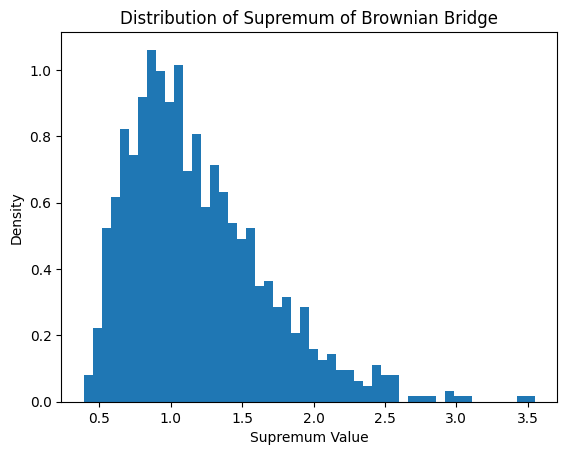

90 quantile: 1.8509489451518497
95 quantile: 2.127159042477907
99 quantile: 2.5964336744993823


100%|██████████| 1000/1000 [00:31<00:00, 32.15it/s]


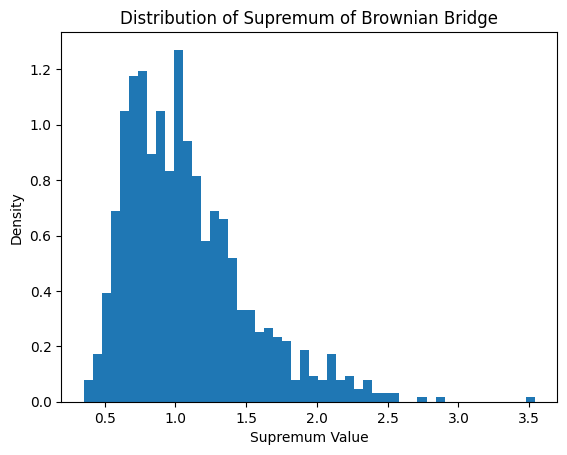

90 quantile: 1.6725276126929924
95 quantile: 1.9461299624602417
99 quantile: 2.365361051654232


100%|██████████| 1000/1000 [00:32<00:00, 30.56it/s]


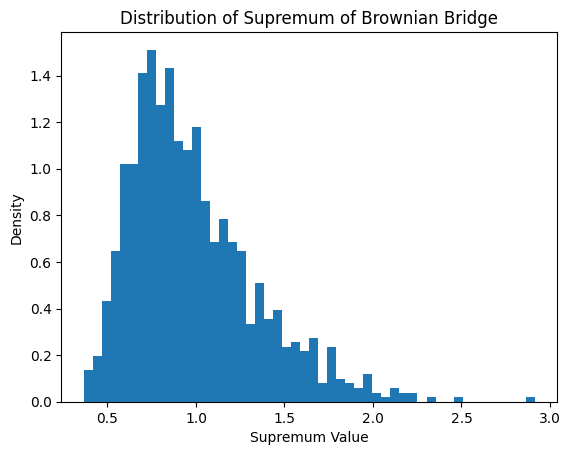

90 quantile: 1.4737527921452784
95 quantile: 1.675124977693312
99 quantile: 2.111495111944811


100%|██████████| 1000/1000 [00:31<00:00, 32.07it/s]


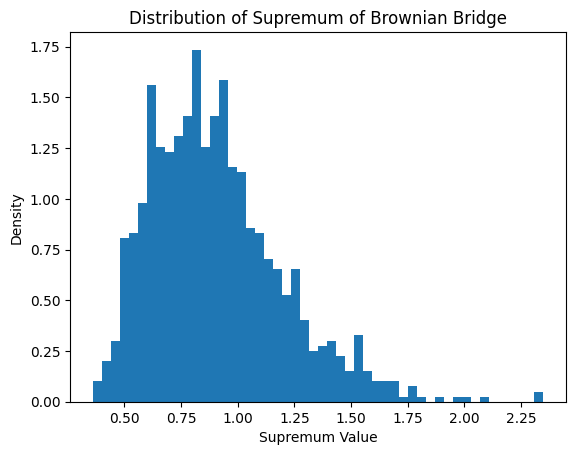

90 quantile: 1.290820554899887
95 quantile: 1.4672634394416753
99 quantile: 1.7543704200026198


 32%|███▏      | 317/1000 [00:10<00:21, 31.47it/s]


KeyboardInterrupt: ignored

In [ ]:
import warnings
warnings.filterwarnings('ignore')
T = 1500
p_coefs = [0.1,0.3,0.5,0.7, 0.9]
params = np.array([0, 0.2, 0.2])
lmbd = 1

sim_mod = arch_model(None, p=1, o=0, q=0, dist="normal")

# Monte Carlo setup
n_simulations = 1000  # Number of Monte Carlo simulations

for p_coef in p_coefs:
  sup_b_values = []
  for _ in tqdm(range(n_simulations)):
      x0 = (np.arange(T) < p_coef * T).astype(int)
      exog = pd.DataFrame({"x0": x0})
      sim_data = sim_mod.simulate(params, nobs=T)
      #sim_data['data'] = exog['x0'] * lmbd + sim_data['data']

      # Model using arch
      model = arch_model(sim_data['data'], x=exog, mean='ARX', lags=0, vol='ARCH', p=1)
      #model = arch_model(sim_data['data'], lags=0, vol='ARCH', p=1)
      res = model.fit(disp="off")

      s = np.arange(1/T, 1 + 1/T, 1/T)
      residuals = np.array(res.resid) -res.params[0]
      residuals_cusum = residuals.cumsum()
      process = (residuals_cusum - np.minimum(s, p_coef) *residuals_cusum[-1] / p_coef) / np.std(residuals) / math.sqrt(T)
      # epsilon = residuals / np.array(res.conditional_volatility)
      # mean_residual = np.mean(residuals)

      # average_corrected_residuals = residuals - mean_residual
      # process = epsilon.cumsum() / np.std(epsilon) / math.sqrt(T)
      # process2 = residuals.cumsum() / np.std(residuals) / math.sqrt(T)
      # process3 = average_corrected_residuals.cumsum() / np.std(residuals) / math.sqrt(T)
      # process4 = average_corrected_residuals.cumsum() / np.std(epsilon) / math.sqrt(T)
      sup_b = np.abs(process).max()

      sup_b_values.append(sup_b)
  supremums = np.array(sup_b_values)
  plt.hist(supremums, bins=50, density=True)
  plt.title("Distribution of Supremum of Brownian Bridge")
  plt.xlabel("Supremum Value")
  plt.ylabel("Density")
  plt.show()
  sorted_supremums = np.sort(supremums)
  critical_95 = sorted_supremums[int(0.95 * len(sorted_supremums))]
  critical_99 = sorted_supremums[int(0.99 * len(sorted_supremums))]
  critical_90 = sorted_supremums[int(0.90 * len(sorted_supremums))]
  print("90 quantile:", critical_90)
  print("95 quantile:", critical_95)
  print("99 quantile:", critical_99)




# Real data

<ipython-input-8-e26ff910ba4b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.rename(columns={' value': 'value'}, inplace=True)
<ipython-input-8-e26ff910ba4b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['value'] = filtered_df['value'].astype(float)
<ipython-input-8-e26ff910ba4b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  value   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                7638.45
Distribution:                  Normal   AIC:                          -15270.9
Method:            Maximum Likelihood   BIC:                          -15255.5
                                        No. Observations:                 1273
Date:                Sun, Aug 20 2023   Df Residuals:                     1272
Time:                        15:38:31   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.4033e-03  1.888e-09  4.451e+06      0.000 [8.

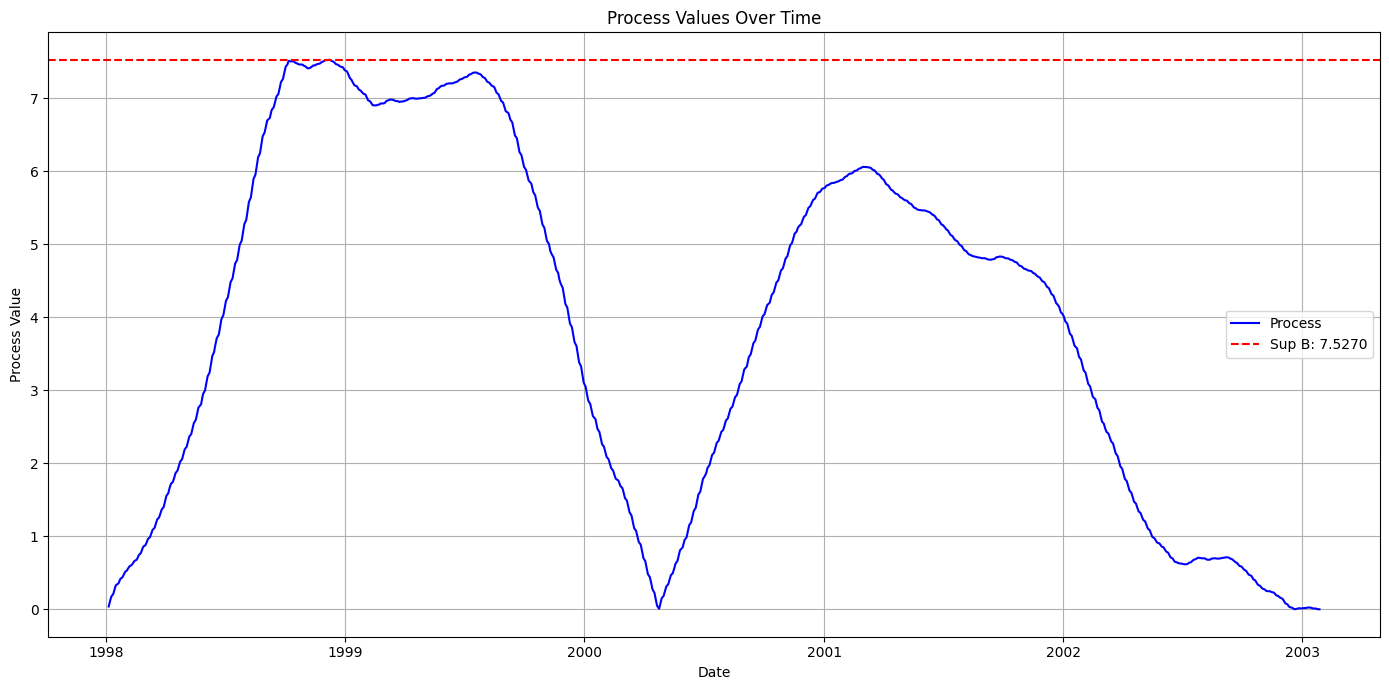

In [ ]:
df = pd.read_csv('dollar-yen-exchange-rate-historical-chart.csv')

# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter the data based on the given date range
filtered_df = df[(df['date'] >= '1998-01-05') & (df['date'] <= '2003-01-27')]

filtered_df.rename(columns={' value': 'value'}, inplace=True)

# Ensure the 'value' column is of type float
filtered_df['value'] = filtered_df['value'].astype(float)
T = len(filtered_df.index)
filtered_df['value'] = 1 / filtered_df['value']

res = arch_model(filtered_df['value'], p=1, o=0, q=0, dist="normal").fit(disp="off")
print(res)
residuals = np.array(res.resid)
#shock_residuals = residuals / np.array(res.conditional_volatility)
#shocl_residuals_squared = residuals**2 / np.array(res.conditional_volatility)**2
# filtered_df['shock_residuals']=residuals
# filtered_df['shocl_residuals_squared']=residuals**2

# filtered_df.to_csv('updated_residuals_filtered_yen_data_set.csv')


# from statsmodels.stats.diagnostic import acorr_ljungbox

# log_returns = np.log(filtered_df['value']).diff().dropna()
# res = arch_model(log_returns, p=1, o=0, q=0, dist="normal").fit(disp="off")


# print(len(filtered_df['value']), len(log_returns))
# print(res)

# test_value = acorr_ljungbox(log_returns,  lags = 1)
# test_value

residuals = np.array(res.resid)
mean_residual = np.mean(residuals)
average_corrected_residuals = residuals - mean_residual
process = np.abs(average_corrected_residuals.cumsum() / np.std(residuals) / math.sqrt(T))
sup_b = np.abs(process).max()
print(sup_b)
filtered_df['process'] = process
filtered_df.to_csv('process_filtered_yen_data_set.csv')


# Plotting
plt.figure(figsize=(14, 7))
plt.plot(filtered_df['date'], process, label='Process', color='blue')
plt.axhline(y=sup_b, color='r', linestyle='--', label=f'Sup B: {sup_b:.4f}')
plt.title('Process Values Over Time')
plt.xlabel('Date')
plt.ylabel('Process Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# date_sup_b_max = filtered_df['date'][np.abs(filtered_df['process']).idxmax()]
# date_sup_b_max



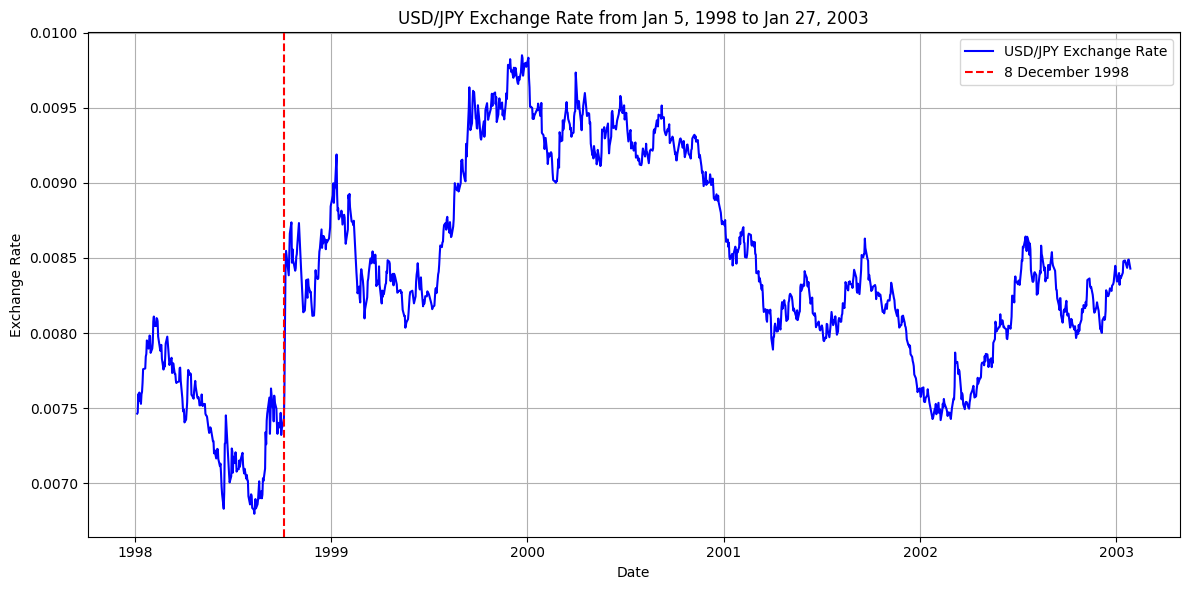

<ipython-input-9-8027d13deba5>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['year_fraction'] = filtered_df['date'].apply(date_to_year_fraction)


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['date'], filtered_df['value'], label='USD/JPY Exchange Rate', color='blue')
plt.axvline(pd.Timestamp('1998-10-05'), color='red', linestyle='--', label='8 December 1998')
plt.title('USD/JPY Exchange Rate from Jan 5, 1998 to Jan 27, 2003')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#filtered_df['value'] = 1/filtered_df['value']
def date_to_year_fraction(date):
    """Convert a date to a year fraction."""
    year = date.year
    start_of_year = pd.Timestamp(year=year, month=1, day=1)
    end_of_year = pd.Timestamp(year=year+1, month=1, day=1)
    year_length = (end_of_year - start_of_year).days
    days_into_year = (date - start_of_year).days

    return year + days_into_year/year_length

# Apply the function to the date column
filtered_df['year_fraction'] = filtered_df['date'].apply(date_to_year_fraction)

# Check the first few rows
filtered_df.head()

filtered_df.to_csv('process_filtered_yen_data_set.csv')

In [ ]:
before_october_df = filtered_df[(filtered_df['date'] >= '1998-01-01') & (filtered_df['date'] <= '1998-10-07')]
after_october_df = filtered_df[(filtered_df['date'] >= '1998-10-7')]
res = arch_model(before_october_df['value'], p=1, o=0, q=0, dist="normal").fit(disp="off")
print(res)
res = arch_model(after_october_df['value'], p=1, o=0, q=0, dist="normal").fit(disp="off")
print(res)

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  value   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                1292.54
Distribution:                  Normal   AIC:                          -2579.07
Method:            Maximum Likelihood   BIC:                          -2569.27
                                        No. Observations:                  194
Date:                Sun, Aug 20 2023   Df Residuals:                      193
Time:                        16:24:46   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.4387e-03  2.169e-08  3.430e+05      0.000 [7.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.16e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.568e-07. Parameter
estimation work better when this value is between 1 and 1000. The recomme

In [ ]:
before_december_df = filtered_df[ (filtered_df['date'] <= '1998-12-08')]
after_december_df = filtered_df[(filtered_df['date'] >= '1998-12-08')]
res = arch_model(before_december_df['value'], p=1, o=0, q=0, dist="normal").fit(disp="off")
print(res)
res = arch_model(after_december_df['value'], p=1, o=0, q=0, dist="normal").fit(disp="off")
print(res)

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  value   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                1492.46
Distribution:                  Normal   AIC:                          -2978.91
Method:            Maximum Likelihood   BIC:                          -2968.53
                                        No. Observations:                  235
Date:                Sun, Aug 20 2023   Df Residuals:                      234
Time:                        16:25:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.6054e-03  7.489e-09  1.015e+06      0.000 [7.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.321e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.682e-07. Parameter
estimation work better when this value is between 1 and 1000. The recomm

### TEST

100%|██████████| 10000/10000 [00:58<00:00, 169.55it/s]


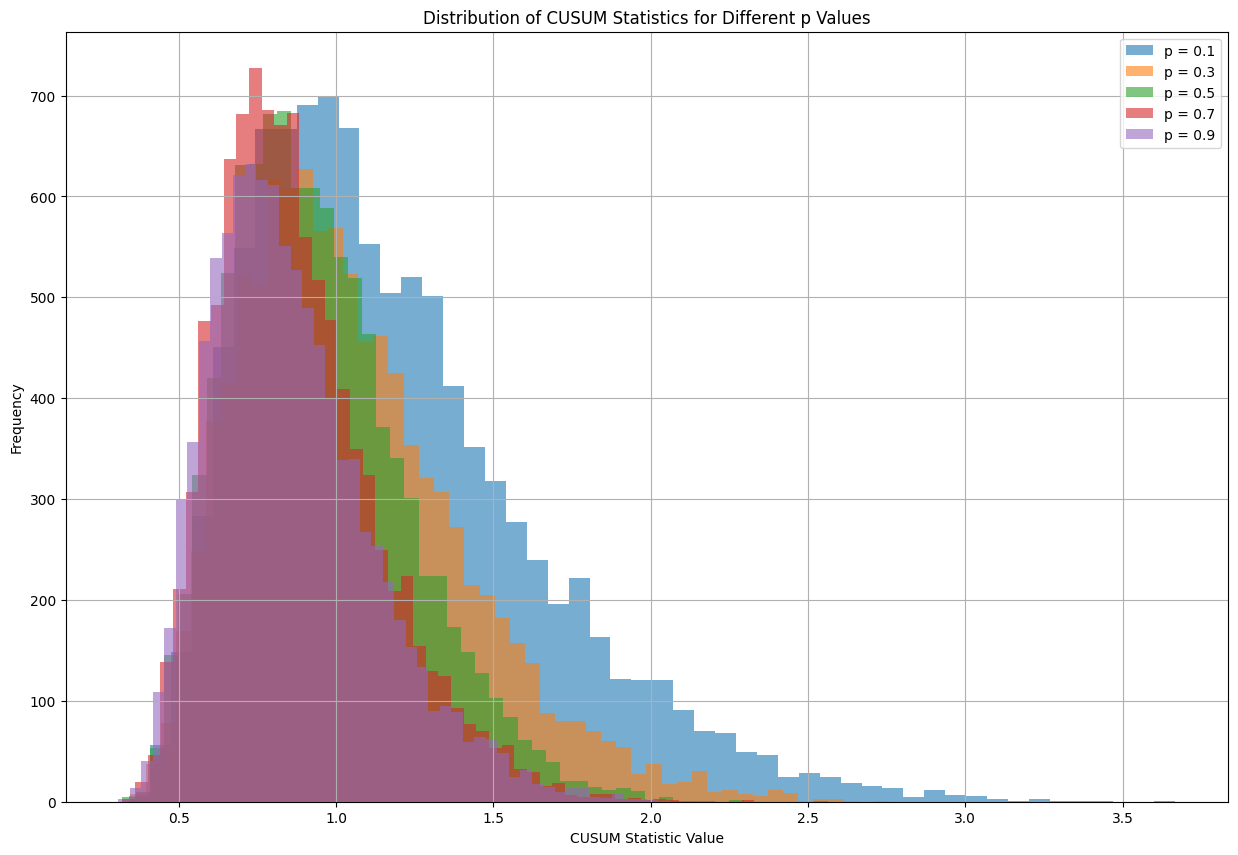

{0.1: {'90%': 1.8119801172990921,
  '95%': 2.0648988460266042,
  '99%': 2.5814629204134047},
 0.3: {'90%': 1.5322938437767373,
  '95%': 1.7217369163995735,
  '99%': 2.109915246400392},
 0.5: {'90%': 1.3293630719470688,
  '95%': 1.4678982814536787,
  '99%': 1.7255923225059724},
 0.7: {'90%': 1.226919534795186,
  '95%': 1.362212400202899,
  '99%': 1.6153581309332568},
 0.9: {'90%': 1.2102630548301943,
  '95%': 1.3580181985171578,
  '99%': 1.6164067123273902}}

In [ ]:
# List of p values
p_values = [0.1, 0.3, 0.5, 0.7, 0.9]
iterations = 10000
# Dictionary to store results
results = {}
T = 10000
lam =1
for p in p_values:
    cusum_stats_p = np.zeros(iterations)

    for i in tqdm(range(iterations)):
        # Simulate the time series
        yt_sim = [lam if t <= p * T else 0 for t in range(T)] + np.random.normal(0, 1, T)

        # Compute residuals
        residuals_sim = yt_sim - [lam if t <= p * T else 0 for t in range(T)]

        # Calculate partial sum of the residuals divided by T
        Ut_s_sim = np.cumsum(residuals_sim) / T

        # Compute CUSUM statistic
        sigma_u_hat_sim = np.std(residuals_sim)
        cusum_stats_p[i] = sigma_u_hat_sim**-1 * np.sqrt(T) * np.max(np.abs(Ut_s_sim - np.minimum(np.arange(1, T+1)/T, p) * Ut_s_sim[-1]))

    # Store the results
    results[p] = {
        'cusum_stats': cusum_stats_p,
        'quantiles_90': np.percentile(cusum_stats_p, 90),
        'quantiles_95': np.percentile(cusum_stats_p, 95),
        'quantiles_99': np.percentile(cusum_stats_p, 99)
    }

# Plot the distributions
plt.figure(figsize=(15, 10))
for p in p_values:
    plt.hist(results[p]['cusum_stats'], bins=50, alpha=0.6, label=f'p = {p}')
plt.title("Distribution of CUSUM Statistics for Different p Values")
plt.xlabel("CUSUM Statistic Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Return quantiles
quantiles_results = {p: {'90%': results[p]['quantiles_90'], '95%': results[p]['quantiles_95'], '99%': results[p]['quantiles_99']} for p in p_values}
quantiles_results


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
T = 1500
params = np.array([0, 0.2, 0.2])
# Monte Carlo setup
n_simulations = 1000  # Number of Monte Carlo simulations


sup_b_values = []
for _ in tqdm(range(n_simulations)):
    lambda_1 = 1
    lambda_2 = 4
    lambda_3 = 10
    lambda_4 = 4
    x1 = (np.arange(T)%4==0).astype(int)
    #print(x1[0:10])
    x2 = (np.arange(T)%4==1).astype(int)
    x3 = (np.arange(T)%4==2).astype(int)
    x4 = (np.arange(T)%4==3).astype(int)
    exog = pd.DataFrame({"x1": x1,"x2": x2,"x3": x3})
    # y = 3 + x1*lambda_1 + x2*lambda_2 + x3*lambda_3 + x4*lambda_4 + np.random.normal(0,1, T)
    # model = LinearRegression()
    # model.fit(exog,y)
    # print(y)
    # coef = model.coef_
    # intercept = model.intercept_
    # print(f"Coefficients: {coef}")
    # print(f"Intercept: {intercept}")

    sim_mod = arch_model(None, p=1, o=0, q=0, dist="normal")
    sim_data = sim_mod.simulate(params, nobs=T)
    sim_data['data'] = sim_data['data']  + exog['x1']*lambda_1 +exog['x2']*lambda_2+ exog['x3']*lambda_3
    #+ exog['x4']*lambda_4
    # plt.figure(figsize=(15, 6))
    # plt.plot(sim_data['data'])
    # plt.title('Generated Time Series')
    # plt.xlabel('Time')
    # plt.ylabel('Value')
    # plt.show()
    model = arch_model(y = sim_data['data'], x = exog, mean='ARX', lags=0, vol='ARCH', p=1)
    #model = arch_model(sim_data['data'], lags=0, vol='ARCH', p=1)
    res = model.fit(disp="off")
    print(res)
    residuals = np.array(res.resid)
    mean_residual = np.mean(residuals)
    average_corrected_residuals = residuals - mean_residual
    average_corrected_residuals_cumsum = average_corrected_residuals.cumsum()
    process = average_corrected_residuals_cumsum / np.std(residuals) / math.sqrt(T)
    sup_b = np.abs(process).max()

    sup_b_values.append(sup_b)

supremums = np.array(sup_b_values)
plt.hist(supremums, bins=50, density=True)
plt.title("Distribution of Supremum of Brownian Bridge")
plt.xlabel("Supremum Value")
plt.ylabel("Density")
plt.show()
sorted_supremums = np.sort(supremums)
critical_95 = sorted_supremums[int(0.95 * len(sorted_supremums))]
critical_99 = sorted_supremums[int(0.99 * len(sorted_supremums))]
critical_90 = sorted_supremums[int(0.90 * len(sorted_supremums))]
print("90 quantile:", critical_90)
print("95 quantile:", critical_95)
print("99 quantile:", critical_99)




# Generate lambda values for each period


# Create seasonal dummies

# Plotting the time series
# plt.figure(figsize=(15, 6))
# plt.plot(y)
# plt.title('Generated Time Series')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.show()


# X = np.column_stack((x1, x2, x3, x4))
# #X = sm.add_constant(X)  # Adding a constant term to the model

# # OLS regression
# model = sm.OLS(y, X)
# results = model.fit()

# # Display the regression results
# results.summary()

  0%|          | 2/1000 [00:00<01:19, 12.51it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.983
Mean Model:                      AR-X   Adj. R-squared:                  0.983
Vol Model:                       ARCH   Log-Likelihood:               -1079.16
Distribution:                  Normal   AIC:                           2170.32
Method:            Maximum Likelihood   BIC:                           2202.20
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:21   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const         -0.0289  2.637e-02     -1.095      0.273 

  1%|          | 6/1000 [00:00<01:29, 11.11it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.984
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1064.88
Distribution:                  Normal   AIC:                           2141.76
Method:            Maximum Likelihood   BIC:                           2173.64
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:21   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0235  2.356e-02      0.997      0.319 

  1%|          | 8/1000 [00:00<01:29, 11.03it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.985
Mean Model:                      AR-X   Adj. R-squared:                  0.985
Vol Model:                       ARCH   Log-Likelihood:               -1036.30
Distribution:                  Normal   AIC:                           2084.59
Method:            Maximum Likelihood   BIC:                           2116.47
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:21   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      4.6718e-03  2.412e-02      0.194      0.846 

  1%|          | 12/1000 [00:01<01:31, 10.85it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.985
Mean Model:                      AR-X   Adj. R-squared:                  0.985
Vol Model:                       ARCH   Log-Likelihood:               -1006.12
Distribution:                  Normal   AIC:                           2024.24
Method:            Maximum Likelihood   BIC:                           2056.12
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:21   Df Model:                            4
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -3.5299e-03  2.422e-02     -0.146      0.

  1%|▏         | 14/1000 [00:01<01:31, 10.75it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.984
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1032.27
Distribution:                  Normal   AIC:                           2076.55
Method:            Maximum Likelihood   BIC:                           2108.43
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:22   Df Model:                            4
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -9.3095e-03  2.351e-02     -0.396      0.

  2%|▏         | 18/1000 [00:01<01:31, 10.74it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.984
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1067.73
Distribution:                  Normal   AIC:                           2147.45
Method:            Maximum Likelihood   BIC:                           2179.33
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:22   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0304  2.496e-02      1.218      0.223 

  2%|▏         | 20/1000 [00:01<01:29, 10.90it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.984
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1054.72
Distribution:                  Normal   AIC:                           2121.43
Method:            Maximum Likelihood   BIC:                           2153.31
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:22   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0174  2.391e-02      0.726      0.468 

  2%|▏         | 22/1000 [00:02<01:31, 10.65it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.984
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1073.74
Distribution:                  Normal   AIC:                           2159.47
Method:            Maximum Likelihood   BIC:                           2191.35
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:23   Df Model:                            4
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -6.9325e-03  2.490e-02     -0.278      0.

  2%|▏         | 24/1000 [00:02<01:37, 10.03it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.983
Mean Model:                      AR-X   Adj. R-squared:                  0.983
Vol Model:                       ARCH   Log-Likelihood:               -1116.39
Distribution:                  Normal   AIC:                           2244.79
Method:            Maximum Likelihood   BIC:                           2276.67
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:23   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const         -0.0240  2.518e-02     -0.954      0.340 

  3%|▎         | 27/1000 [00:02<01:49,  8.85it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.983
Mean Model:                      AR-X   Adj. R-squared:                  0.983
Vol Model:                       ARCH   Log-Likelihood:               -1095.54
Distribution:                  Normal   AIC:                           2203.07
Method:            Maximum Likelihood   BIC:                           2234.95
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:23   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const         -0.0225  2.501e-02     -0.898      0.369 

  3%|▎         | 29/1000 [00:02<02:05,  7.72it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.984
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1047.57
Distribution:                  Normal   AIC:                           2107.14
Method:            Maximum Likelihood   BIC:                           2139.02
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:23   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const         -0.0129  2.531e-02     -0.508      0.611 

  3%|▎         | 31/1000 [00:03<02:15,  7.15it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.984
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1085.11
Distribution:                  Normal   AIC:                           2182.22
Method:            Maximum Likelihood   BIC:                           2214.10
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:24   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      1.6225e-03  2.490e-02  6.517e-02      0.948 

  3%|▎         | 33/1000 [00:03<02:22,  6.77it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.983
Mean Model:                      AR-X   Adj. R-squared:                  0.983
Vol Model:                       ARCH   Log-Likelihood:               -1098.38
Distribution:                  Normal   AIC:                           2208.76
Method:            Maximum Likelihood   BIC:                           2240.64
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:24   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0204  2.525e-02      0.806      0.420 

  4%|▎         | 35/1000 [00:03<02:27,  6.54it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.983
Mean Model:                      AR-X   Adj. R-squared:                  0.983
Vol Model:                       ARCH   Log-Likelihood:               -1062.40
Distribution:                  Normal   AIC:                           2136.79
Method:            Maximum Likelihood   BIC:                           2168.67
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:24   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0228  2.489e-02      0.916      0.360 

  4%|▎         | 37/1000 [00:04<02:24,  6.67it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.985
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1029.10
Distribution:                  Normal   AIC:                           2070.21
Method:            Maximum Likelihood   BIC:                           2102.09
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:25   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const         -0.0248  2.420e-02     -1.023      0.306 

  4%|▍         | 40/1000 [00:04<01:53,  8.45it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.984
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1036.01
Distribution:                  Normal   AIC:                           2084.02
Method:            Maximum Likelihood   BIC:                           2115.90
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:25   Df Model:                            4
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -5.1654e-03  2.480e-02     -0.208      0.

  4%|▍         | 42/1000 [00:04<01:41,  9.44it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.984
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1078.63
Distribution:                  Normal   AIC:                           2169.25
Method:            Maximum Likelihood   BIC:                           2201.13
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:25   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const         -0.0271  2.508e-02     -1.079      0.281 

  5%|▍         | 46/1000 [00:05<01:32, 10.34it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.983
Mean Model:                      AR-X   Adj. R-squared:                  0.983
Vol Model:                       ARCH   Log-Likelihood:               -1100.71
Distribution:                  Normal   AIC:                           2213.41
Method:            Maximum Likelihood   BIC:                           2245.29
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:25   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0243  2.526e-02      0.961      0.337 

  5%|▍         | 48/1000 [00:05<01:29, 10.64it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.984
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1077.95
Distribution:                  Normal   AIC:                           2167.90
Method:            Maximum Likelihood   BIC:                           2199.78
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:26   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      9.2395e-03  2.494e-02      0.370      0.711 

  5%|▌         | 52/1000 [00:05<01:25, 11.13it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.983
Mean Model:                      AR-X   Adj. R-squared:                  0.983
Vol Model:                       ARCH   Log-Likelihood:               -1094.16
Distribution:                  Normal   AIC:                           2200.33
Method:            Maximum Likelihood   BIC:                           2232.21
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:26   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0250  2.501e-02      1.001      0.317 

  5%|▌         | 54/1000 [00:05<01:24, 11.18it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.983
Mean Model:                      AR-X   Adj. R-squared:                  0.983
Vol Model:                       ARCH   Log-Likelihood:               -1106.83
Distribution:                  Normal   AIC:                           2225.67
Method:            Maximum Likelihood   BIC:                           2257.55
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:26   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0280  2.551e-02      1.097      0.273 

  6%|▌         | 58/1000 [00:06<01:23, 11.24it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.984
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1034.91
Distribution:                  Normal   AIC:                           2081.82
Method:            Maximum Likelihood   BIC:                           2113.70
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:26   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0241  2.335e-02      1.034      0.301 

  6%|▌         | 60/1000 [00:06<01:25, 11.02it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.983
Mean Model:                      AR-X   Adj. R-squared:                  0.983
Vol Model:                       ARCH   Log-Likelihood:               -1076.37
Distribution:                  Normal   AIC:                           2164.75
Method:            Maximum Likelihood   BIC:                           2196.63
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:27   Df Model:                            4
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -7.5090e-03  2.370e-02     -0.317      0.

  6%|▋         | 64/1000 [00:06<01:23, 11.17it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.984
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1061.55
Distribution:                  Normal   AIC:                           2135.10
Method:            Maximum Likelihood   BIC:                           2166.98
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:27   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const         -0.0340  2.322e-02     -1.463      0.143 

  7%|▋         | 66/1000 [00:06<01:24, 11.06it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.984
Mean Model:                      AR-X   Adj. R-squared:                  0.984
Vol Model:                       ARCH   Log-Likelihood:               -1050.86
Distribution:                  Normal   AIC:                           2113.72
Method:            Maximum Likelihood   BIC:                           2145.60
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:27   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const         -0.0110  2.491e-02     -0.440      0.660 

  7%|▋         | 68/1000 [00:07<01:36,  9.70it/s]

                          AR-X - ARCH Model Results                           
Dep. Variable:                   data   R-squared:                       0.983
Mean Model:                      AR-X   Adj. R-squared:                  0.983
Vol Model:                       ARCH   Log-Likelihood:               -1071.77
Distribution:                  Normal   AIC:                           2155.54
Method:            Maximum Likelihood   BIC:                           2187.42
                                        No. Observations:                 1500
Date:                Thu, Aug 24 2023   Df Residuals:                     1496
Time:                        17:07:27   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      3.9864e-05  2.355e-02  1.693e-03      0.999 

KeyboardInterrupt: ignored